# Install + Hugging Face login



In [2]:
# Install the official SAP RPT-1 OSS library + dependencies
!pip install -q git+https://github.com/SAP-samples/sap-rpt-1-oss.git
!pip install -q transformers torch pandas scikit-learn huggingface_hub

from huggingface_hub import login
import os

HF_TOKEN = None

# Try different sources for the token
try:
    # 1.Try from Colab
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ Token obtained from Colab secrets")
except:
    try:
        # 2. Try from environment variable
        HF_TOKEN = os.getenv('HF_TOKEN')
        if HF_TOKEN:
            print("✓ Token obtained from environment variable")
    except:
        pass

if HF_TOKEN:
    login(token=HF_TOKEN)
    print("Login successful! Ready to download RPT-1 OSS")
else:
    print("Error: Unable to obtain HF_TOKEN")
    print("\nSolution:")
    print("- In Colab: Go to Secrets → Add 'HF_TOKEN' with your token")
    print("- In VS Code: Create an .env file with: HF_TOKEN=your_token")

  Preparing metadata (setup.py) ... done
✓ Token obtained from Colab secrets
Login successful! Ready to download RPT-1 OSS


# Generation of Sysnthetic Data simulating serveral S/4HANA CDS Views.
1. MATERIAL MASTER DATA (I_ProductPlantBasic)
2. CURRENT STOCK (I_MaterialStock)
3. CONSUMPTION PATTERNS (I_MaterialDocumentItem aggregated)
4. DEMAND TREND (Last 30 days vs previous 30)
5. PLANNING PARAMETERS (I_ProductPlantBasic)
6. SUPPLIER DATA (I_Supplier + I_PurchasingInfoRecord)
7. OPEN PURCHASE ORDERS (I_PurchaseOrderItemAPI01)
8. ADDITIONAL RISK SIGNALS
9. TARGET VARIABLE: STOCKOUT_RISK_14D
10. DataSet
    * JSON
    * CSV
11. VISUALIZATIONS
    * SAP S/4HANA Stockout Risk Analysis Dashboard
      * Risk distribution (only labeled materials)
      * Days of supply by ABC class
      * Supplier reliability distribution
      * Stock vs Reorder Point
      * Demand trend
      * Materials with open purchase orders
    * Correlation heatmap
    * Lead Time Deviation Distribution
    * Risk vs ABC Class Heatmap

Generating realistic SAP S/4HANA stockout risk dataset...

GENERATING VISUALIZATIONS...


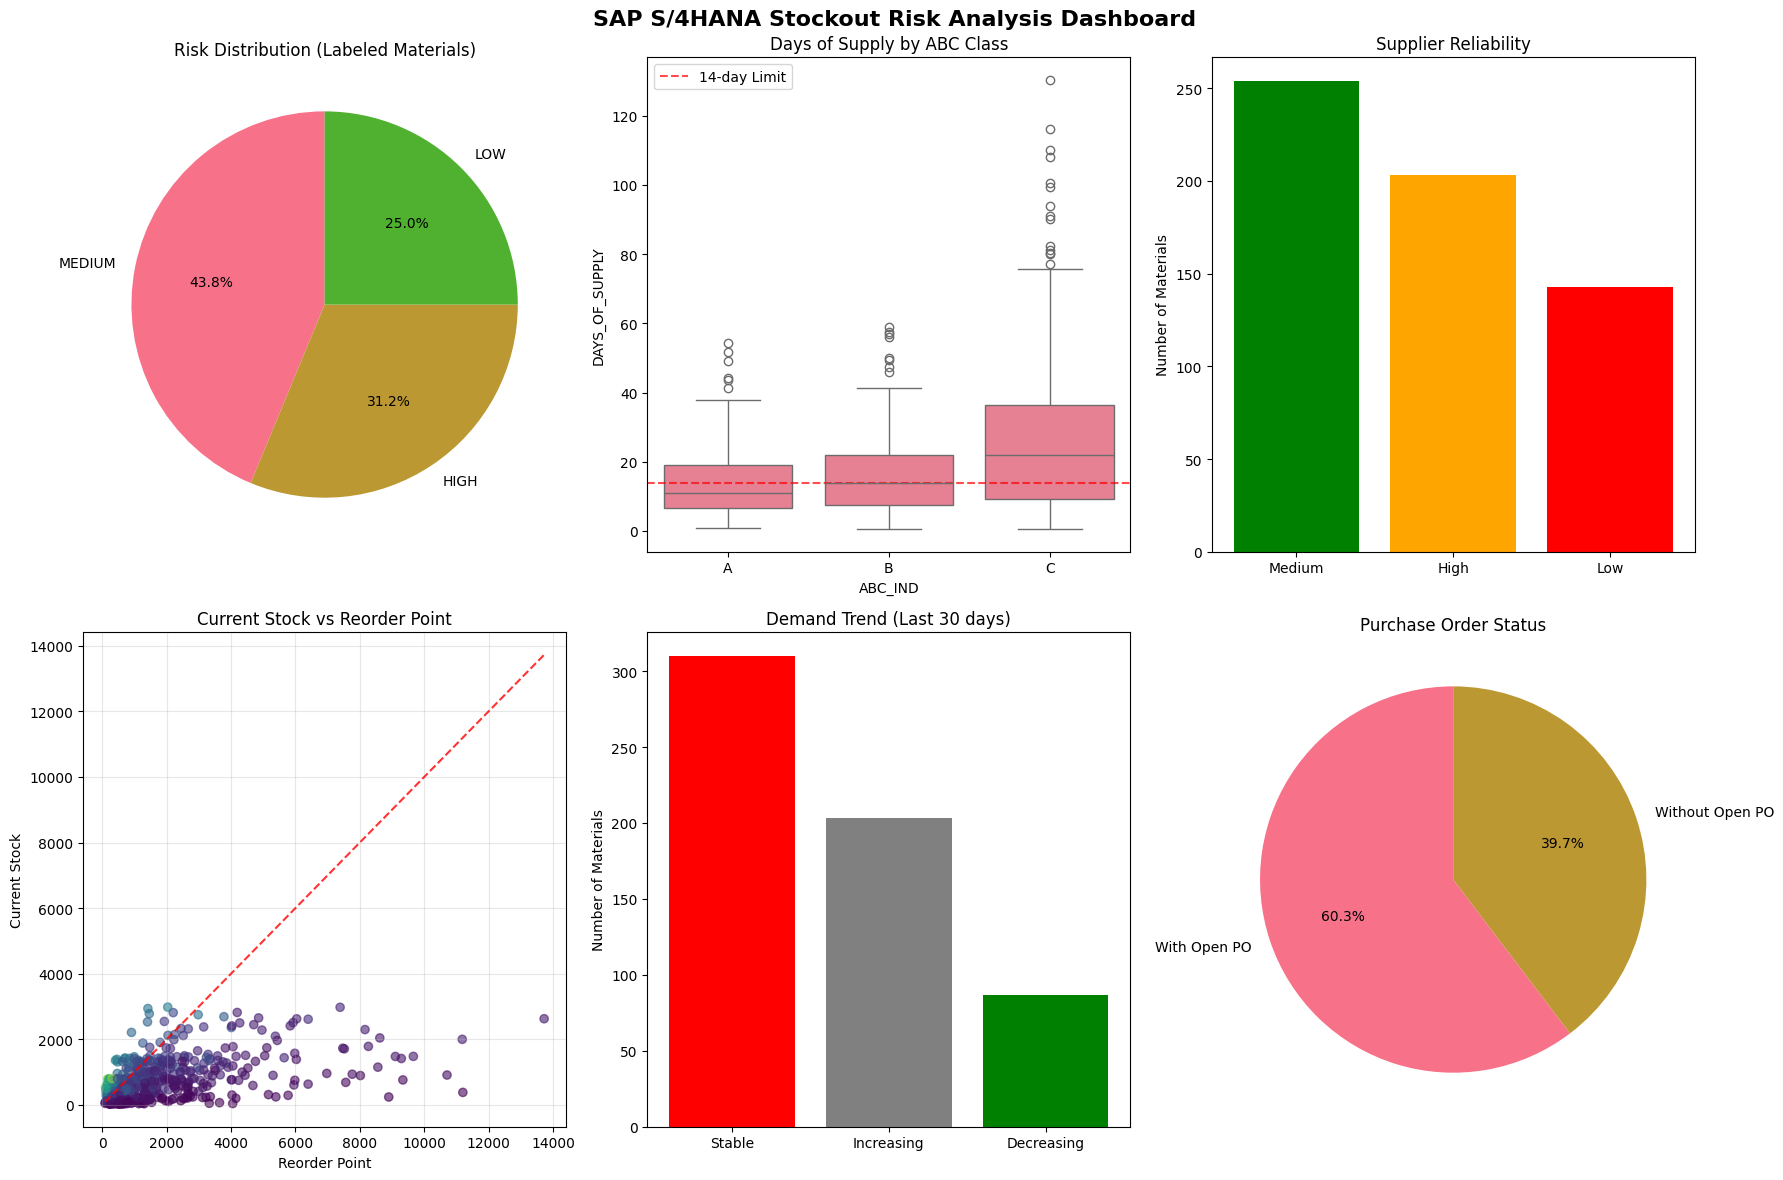


📈 Generating correlation heatmap...


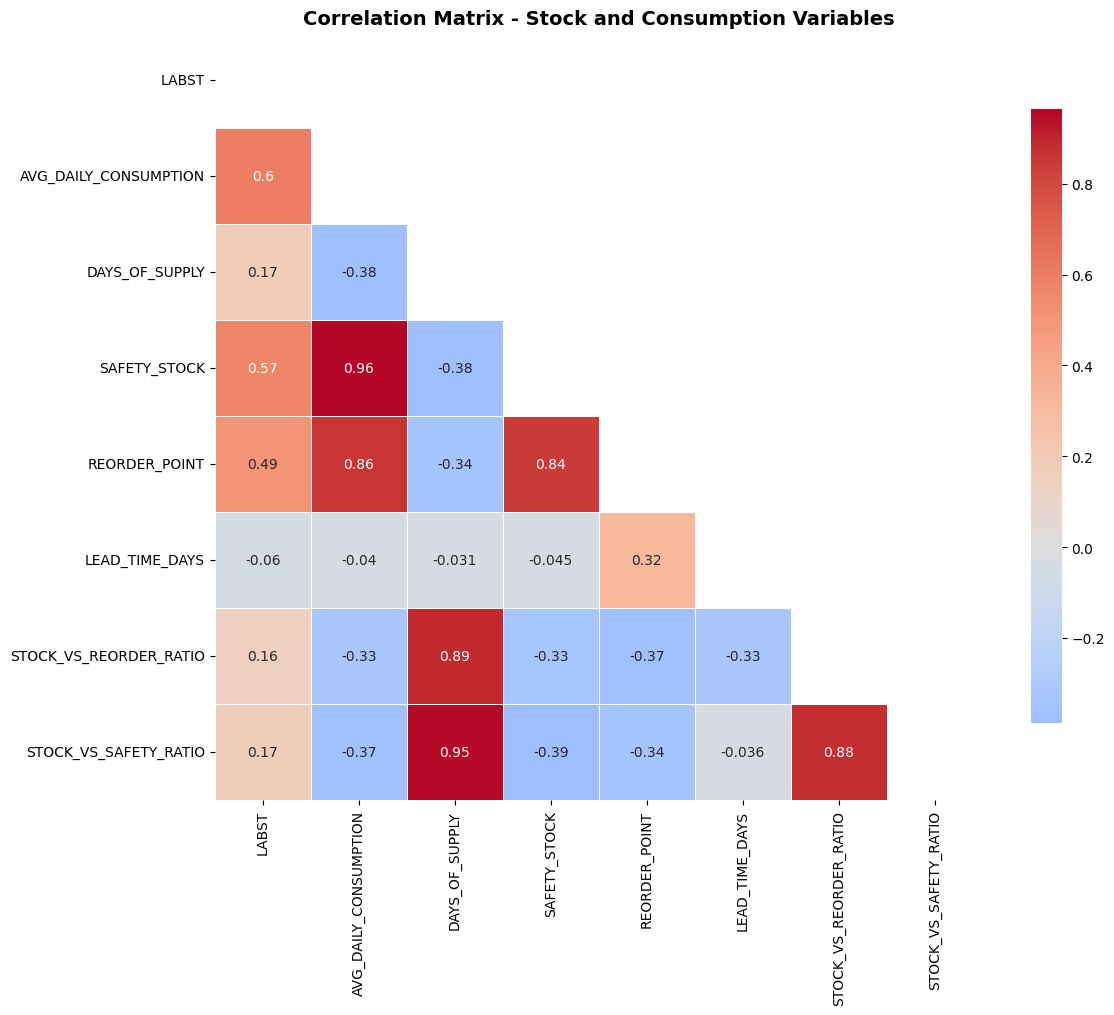

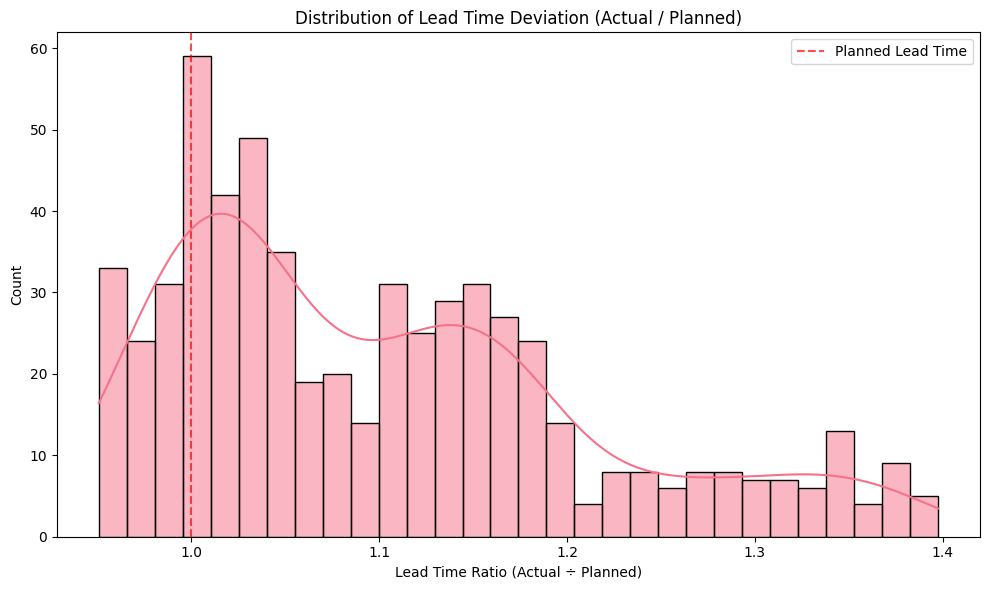

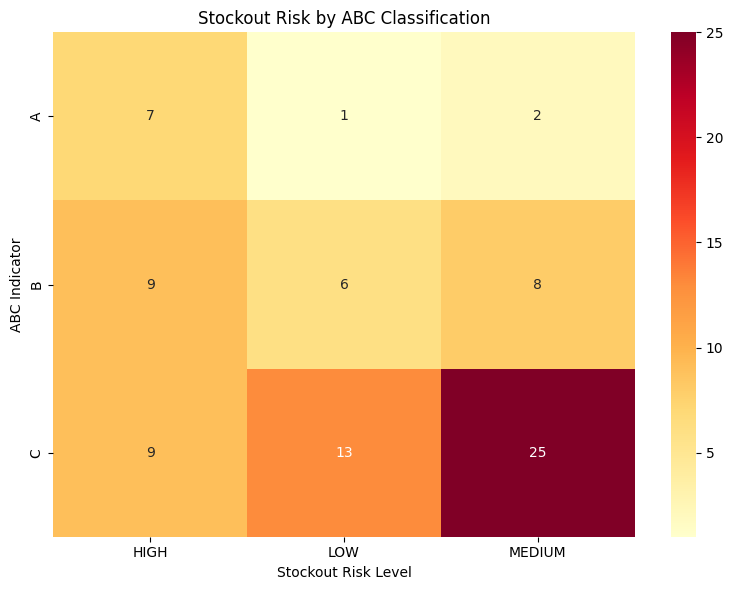


DATASET GENERATED SUCCESSFULLY

Total materials: 600
Plants: 3 → ['1030', '1010', '1020']
Suppliers: 8

--- ABC Distribution ---
ABC_IND
A     91
B    202
C    307
Name: count, dtype: int64

--- Known Risk Labels (few-shot examples) ---
Total labeled: 80 materials (13.3%)
STOCKOUT_RISK_14D
MEDIUM    35
HIGH      25
LOW       20
Name: count, dtype: Int64

--- Materials to predict ---
Unlabeled: 520 materials

--- Stock Coverage Stats ---
Days of supply - Mean: 21.5
Days of supply - Median: 16.2
Materials with <14 days coverage: 264 (44.0%)
Materials with <7 days coverage: 128 (21.3%)

--- Open POs ---
Materials with open PO: 362 (60.3%)
Materials without PO: 238

--- Supplier Reliability ---
SUPPLIER_RELIABILITY
Medium    254
High      203
Low       143
Name: count, dtype: int64

Files saved:
- realistic_stockout_risk_600_materials.json
- realistic_stockout_risk_600_materials.csv
- stockout_risk_dashboard.png
- correlation_heatmap.png

📊 Sample of HIGH RISK materials (known labels):
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading CSV dataset...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading dashboard PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading correlation heatmap PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading lead time deviation PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading risk ABC heatmap PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 All files downloaded successfully!
📁 Files available in your local downloads folder:
   - realistic_stockout_risk_600_materials.json
   - realistic_stockout_risk_600_materials.csv
   - stockout_risk_dashboard.png
   - correlation_heatmap.png

🚀 Dataset ready for SAP RPT-1 analysis!


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Configure plotting style
plt.style.use('default')
sns.set_palette("husl")

np.random.seed(42)

# Realistic configuration
n_materials = 600
n_plants = 3
n_suppliers = 8

print("Generating realistic SAP S/4HANA stockout risk dataset...")

# ============================================
# 1. MATERIAL MASTER DATA (I_ProductPlantBasic)
# ============================================

plants = ['1010', '1020', '1030']
material_types = ['ROH', 'HALB', 'FERT']  # Raw, Semi-finished, Finished
abc_classes = ['A', 'B', 'C']
mrp_types = ['PD', 'VB', 'ND']  # MRP, Reorder point, No planning

data = {
    'MATNR': [f'MAT{i:06d}' for i in range(1, n_materials+1)],
    'WERKS': np.random.choice(plants, n_materials).tolist(),
    'MTART': np.random.choice(material_types, n_materials, p=[0.4, 0.3, 0.3]).tolist(),
    'MATKL': np.random.choice(['MECH', 'ELEC', 'CHEM', 'PACK'], n_materials).tolist(),
    'ABC_IND': np.random.choice(abc_classes, n_materials, p=[0.15, 0.35, 0.50]).tolist(),
    'MRP_TYPE': np.random.choice(mrp_types, n_materials, p=[0.6, 0.3, 0.1]).tolist(),
}

df = pd.DataFrame(data)

# ============================================
# 2. CURRENT STOCK (I_MaterialStock)
# ============================================

# Realistic stock based on type and ABC classification
def generate_stock(row):
    if row['ABC_IND'] == 'A':
        base_stock = np.random.randint(500, 3000)
    elif row['ABC_IND'] == 'B':
        base_stock = np.random.randint(200, 1500)
    else:  # C
        base_stock = np.random.randint(50, 800)

    # 10% of materials with very low stock (critical situation)
    if np.random.random() < 0.10:
        base_stock = int(base_stock * 0.15)

    return base_stock

df['LABST'] = df.apply(generate_stock, axis=1).tolist()

# Blocked stock (5-15% of total in some cases)
df['SPEME'] = np.where(
    np.random.random(n_materials) < 0.15,  # 15% have blocked stock
    (df['LABST'] * np.random.uniform(0.05, 0.15, n_materials)).astype(int),
    0
).tolist()

# ============================================
# 3. CONSUMPTION PATTERNS (I_MaterialDocumentItem aggregated)
# ============================================

def generate_consumption(row):
    base_consumption = {
        'A': (50, 250),   # High runners
        'B': (20, 100),   # Medium
        'C': (5, 30)      # Slow movers
    }

    min_cons, max_cons = base_consumption[row['ABC_IND']]
    avg = np.random.uniform(min_cons, max_cons)

    # Std dev is ~30% of average (realistic volatility)
    std = avg * np.random.uniform(0.2, 0.4)

    # Max is ~2-3x average (demand peaks)
    max_val = avg * np.random.uniform(2.0, 3.5)

    return pd.Series({
        'avg': round(avg, 2),
        'std': round(std, 2),
        'max': round(max_val, 2)
    })

consumption = df.apply(generate_consumption, axis=1)
df['AVG_DAILY_CONSUMPTION'] = consumption['avg'].tolist()
df['STD_DEV_CONSUMPTION'] = consumption['std'].tolist()
df['MAX_DAILY_CONSUMPTION'] = consumption['max'].tolist()

# Days of supply current coverage (key metric!)
df['DAYS_OF_SUPPLY'] = np.round(df['LABST'] / df['AVG_DAILY_CONSUMPTION'].replace(0, 1), 1).tolist()

# ============================================
# 4. DEMAND TREND (Last 30 days vs previous 30)
# ============================================

def assign_trend(days_of_supply, abc):
    if days_of_supply < 10:
        # If already low, likely increasing trend
        return np.random.choice(['Increasing', 'Stable', 'Decreasing'], p=[0.6, 0.3, 0.1])
    elif abc == 'A':
        return np.random.choice(['Increasing', 'Stable', 'Decreasing'], p=[0.3, 0.5, 0.2])
    else:
        return np.random.choice(['Increasing', 'Stable', 'Decreasing'], p=[0.2, 0.6, 0.2])

df['DEMAND_TREND_30D'] = df.apply(lambda x: assign_trend(x['DAYS_OF_SUPPLY'], x['ABC_IND']), axis=1).tolist()

# ============================================
# 5. PLANNING PARAMETERS (I_ProductPlantBasic)
# ============================================

# Safety stock = ~7-14 days of average consumption
df['SAFETY_STOCK'] = (df['AVG_DAILY_CONSUMPTION'] * np.random.uniform(7, 14, n_materials)).astype(int).tolist()

# Reorder point = safety stock + lead time demand
lead_time_days_options = [7, 10, 14, 21, 30, 45, 60]
df['LEAD_TIME_DAYS'] = np.random.choice(
    lead_time_days_options,
    n_materials,
    p=[0.05, 0.15, 0.25, 0.25, 0.15, 0.10, 0.05]  # Most common: 14-21 days
).tolist()

df['REORDER_POINT'] = (
    df['SAFETY_STOCK'] +
    (df['AVG_DAILY_CONSUMPTION'] * df['LEAD_TIME_DAYS'])
).astype(int).tolist()

# ============================================
# 6. SUPPLIER DATA (I_Supplier + I_PurchasingInfoRecord)
# ============================================

suppliers = [f'V{i:04d}' for i in range(1, n_suppliers+1)]
df['LIFNR'] = np.random.choice(suppliers, n_materials).tolist()

# Supplier reliability (based on historical on-time delivery)
supplier_reliability_map = {
    'V0001': 'High',    # 95%+ on-time
    'V0002': 'High',    # 93%+
    'V0003': 'Medium',  # 85-90%
    'V0004': 'Medium',  # 80-85%
    'V0005': 'Medium',  # 85-90%
    'V0006': 'Low',     # 70-75%
    'V0007': 'Low',     # 65-70%
    'V0008': 'High',    # 90%+
}

df['SUPPLIER_RELIABILITY'] = df['LIFNR'].map(supplier_reliability_map).tolist()

'''
# Actual lead time vs planned (supplier performance)
df['ACTUAL_VS_PLANNED_LT'] = df['SUPPLIER_RELIABILITY'].map({
    'High': np.random.uniform(0.95, 1.05),    # ±5%
    'Medium': np.random.uniform(1.0, 1.20),   # +0-20%
    'Low': np.random.uniform(1.10, 1.40)      # +10-40%
}).tolist()
'''
def random_lt(rel):
    if rel == "High":
        return np.random.uniform(0.95, 1.05)
    elif rel == "Medium":
        return np.random.uniform(1.0, 1.20)
    else:  # Low
        return np.random.uniform(1.10, 1.40)

df['ACTUAL_VS_PLANNED_LT'] = df['SUPPLIER_RELIABILITY'].apply(random_lt)

# ============================================
# 7. OPEN PURCHASE ORDERS (I_PurchaseOrderItemAPI01)
# ============================================

# 60% of materials have open PO
has_open_po = np.random.random(n_materials) < 0.60

df['OPEN_PO_QTY'] = np.where(
    has_open_po,
    (df['AVG_DAILY_CONSUMPTION'] * np.random.uniform(10, 30, n_materials)).astype(int),
    0
).tolist()

# Delivery date of open PO (days from today)
def calculate_po_delivery(row):
    if row['OPEN_PO_QTY'] == 0:
        return -999  # No open PO

    # Realistic: POs usually arrive within 7-30 days.
    # But some are delayed (>lead time)
    if row['SUPPLIER_RELIABILITY'] == 'Low' and np.random.random() < 0.3:
        # 30% of purchase orders from poor suppliers are delayed.
        return np.random.randint(row['LEAD_TIME_DAYS'] + 5, row['LEAD_TIME_DAYS'] + 20)
    else:
        return np.random.randint(3, min(row['LEAD_TIME_DAYS'] + 5, 30))

df['OPEN_PO_DELIVERY_DAYS'] = df.apply(calculate_po_delivery, axis=1).tolist()

# ============================================
# 8. ADDITIONAL RISK SIGNALS
# ============================================

# Ratio: current stock vs reorder point
df['STOCK_VS_REORDER_RATIO'] = np.round(df['LABST'] / df['REORDER_POINT'].replace(0, 1), 2).tolist()

# Ratio: current stock vs safety stock
df['STOCK_VS_SAFETY_RATIO'] = np.round(df['LABST'] / df['SAFETY_STOCK'].replace(0, 1), 2).tolist()

# Coverage until next instalment (if there is a PO)
df['COVERAGE_UNTIL_NEXT_PO'] = np.where(
    df['OPEN_PO_DELIVERY_DAYS'] > 0,
    df['DAYS_OF_SUPPLY'] - df['OPEN_PO_DELIVERY_DAYS'],
    -999
).tolist()

# ============================================
# 9. TARGET VARIABLE: STOCKOUT_RISK_14D
# ============================================

# Realistic logic for determining risk
def calculate_stockout_risk(row):
    """
    Calculate the risk of stockouts in the next 14 days
    Based on multiple factors, as an expert planner would do
    """
    risk_score = 0

    # Factor 1: Days of coverage
    if row['DAYS_OF_SUPPLY'] < 7:
        risk_score += 4
    elif row['DAYS_OF_SUPPLY'] < 14:
        risk_score += 3
    elif row['DAYS_OF_SUPPLY'] < 21:
        risk_score += 1

    # Factor 2: Stock vs safety stock
    if row['STOCK_VS_SAFETY_RATIO'] < 0.5:
        risk_score += 3
    elif row['STOCK_VS_SAFETY_RATIO'] < 1.0:
        risk_score += 2
    elif row['STOCK_VS_SAFETY_RATIO'] < 1.5:
        risk_score += 1

    # Factor 3: PO coverage
    if row['OPEN_PO_DELIVERY_DAYS'] == -999:  # No PO
        risk_score += 3
    elif row['OPEN_PO_DELIVERY_DAYS'] > row['DAYS_OF_SUPPLY']:
        risk_score += 2  # PO arrives after stockout
    elif row['OPEN_PO_DELIVERY_DAYS'] > 14:
        risk_score += 1  # Distant PO

    # Factor 4: Supplier reliability
    if row['SUPPLIER_RELIABILITY'] == 'Low':
        risk_score += 2
    elif row['SUPPLIER_RELIABILITY'] == 'Medium':
        risk_score += 1

    # Factor 5: Demand trend
    if row['DEMAND_TREND_30D'] == 'Increasing':
        risk_score += 2
    elif row['DEMAND_TREND_30D'] == 'Decreasing':
        risk_score -= 1

    # Factor 6: Criticality (ABC)
    if row['ABC_IND'] == 'A':
        risk_score += 1  # More sensitive to stockouts

    # Factor 7: Demand volatility
    cv = row['STD_DEV_CONSUMPTION'] / row['AVG_DAILY_CONSUMPTION']  # Coefficient of variation
    if cv > 0.5:  # High volatility
        risk_score += 2
    elif cv > 0.3:
        risk_score += 1

    # Final standings
    if risk_score >= 8:
        return 'HIGH'
    elif risk_score >= 5:
        return 'MEDIUM'
    else:
        return 'LOW'

# Create target for subset of materials (few-shot learning scenario)
df['STOCKOUT_RISK_14D'] = pd.NA
df['STOCKOUT_RISK_14D'] = df['STOCKOUT_RISK_14D'].astype('string')

# Select 80 materials with known labels (mixed by criticality)
high_risk_candidates = df[df.apply(calculate_stockout_risk, axis=1) == 'HIGH'].sample(n=min(25, len(df)), random_state=42)
medium_risk_candidates = df[df.apply(calculate_stockout_risk, axis=1) == 'MEDIUM'].sample(n=min(35, len(df)), random_state=42)
low_risk_candidates = df[df.apply(calculate_stockout_risk, axis=1) == 'LOW'].sample(n=min(20, len(df)), random_state=42)

known_indices = pd.concat([high_risk_candidates, medium_risk_candidates, low_risk_candidates]).index

for idx in known_indices:
    df.loc[idx, 'STOCKOUT_RISK_14D'] = calculate_stockout_risk(df.loc[idx])

# ============================================
# 10. FINAL DATASET
# ============================================

# Reorder columns to make it more readable
column_order = [
    'MATNR', 'WERKS', 'MTART', 'MATKL', 'ABC_IND', 'MRP_TYPE',
    'LABST', 'SPEME',
    'AVG_DAILY_CONSUMPTION', 'STD_DEV_CONSUMPTION', 'MAX_DAILY_CONSUMPTION',
    'DAYS_OF_SUPPLY', 'DEMAND_TREND_30D',
    'SAFETY_STOCK', 'REORDER_POINT', 'LEAD_TIME_DAYS',
    'STOCK_VS_REORDER_RATIO', 'STOCK_VS_SAFETY_RATIO',
    'LIFNR', 'SUPPLIER_RELIABILITY', 'ACTUAL_VS_PLANNED_LT',
    'OPEN_PO_QTY', 'OPEN_PO_DELIVERY_DAYS', 'COVERAGE_UNTIL_NEXT_PO',
    'STOCKOUT_RISK_14D'
]

df = df[column_order]

# Convert to dictionary for JSON
dataset_dict = df.to_dict('records')

# Save to JSON
with open('realistic_stockout_risk_600_materials.json', 'w') as f:
    json.dump(dataset_dict, f, indent=2)

# Also save to CSV (but with clean data)
df_clean = df.copy()
# Ensure all values are scalars
for col in df_clean.columns:
    df_clean[col] = df_clean[col].apply(lambda x: x if not hasattr(x, '__len__') or isinstance(x, str) else x.item() if hasattr(x, 'item') else x)

df_clean.to_csv('realistic_stockout_risk_600_materials.csv', index=False)

# ============================================
# VISUALIZATIONS
# ============================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS...")
print("="*60)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('SAP S/4HANA Stockout Risk Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Risk distribution (only labeled materials)
known_df = df[df['STOCKOUT_RISK_14D'].notna()]
if not known_df.empty:
    risk_counts = known_df['STOCKOUT_RISK_14D'].value_counts()
    axes[0,0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Risk Distribution (Labeled Materials)')

# 2. Days of supply by ABC class
sns.boxplot(data=df, x='ABC_IND', y='DAYS_OF_SUPPLY', ax=axes[0,1])
axes[0,1].set_title('Days of Supply by ABC Class')
axes[0,1].axhline(y=14, color='r', linestyle='--', alpha=0.7, label='14-day Limit')
axes[0,1].legend()

# 3. Supplier reliability distribution
supplier_rel = df['SUPPLIER_RELIABILITY'].value_counts()
axes[0,2].bar(supplier_rel.index, supplier_rel.values, color=['green', 'orange', 'red'])
axes[0,2].set_title('Supplier Reliability')
axes[0,2].set_ylabel('Number of Materials')

# 4. Stock vs Reorder Point
axes[1,0].scatter(df['REORDER_POINT'], df['LABST'], alpha=0.6, c=df['DAYS_OF_SUPPLY'], cmap='viridis')
axes[1,0].plot([df['REORDER_POINT'].min(), df['REORDER_POINT'].max()],
               [df['REORDER_POINT'].min(), df['REORDER_POINT'].max()], 'r--', alpha=0.8)
axes[1,0].set_xlabel('Reorder Point')
axes[1,0].set_ylabel('Current Stock')
axes[1,0].set_title('Current Stock vs Reorder Point')
axes[1,0].grid(True, alpha=0.3)

# 5. Demand trend
trend_counts = df['DEMAND_TREND_30D'].value_counts()
axes[1,1].bar(trend_counts.index, trend_counts.values, color=['red', 'gray', 'green'])
axes[1,1].set_title('Demand Trend (Last 30 days)')
axes[1,1].set_ylabel('Number of Materials')

# 6. Materials with open purchase orders
po_status = ['With Open PO', 'Without Open PO']
po_counts = [(df['OPEN_PO_QTY'] > 0).sum(), (df['OPEN_PO_QTY'] == 0).sum()]
axes[1,2].pie(po_counts, labels=po_status, autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Purchase Order Status')

plt.tight_layout()

# Save dashboard as PNG
plt.savefig('stockout_risk_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Correlation heatmap
print("\n📈 Generating correlation heatmap...")
plt.figure(figsize=(12, 10))

# Select numeric columns for correlation
numeric_cols = ['LABST', 'AVG_DAILY_CONSUMPTION', 'DAYS_OF_SUPPLY', 'SAFETY_STOCK',
                'REORDER_POINT', 'LEAD_TIME_DAYS', 'STOCK_VS_REORDER_RATIO',
                'STOCK_VS_SAFETY_RATIO']

corr_df = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.heatmap(corr_df, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Stock and Consumption Variables', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save heatmap as PNG
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ===========================================================
# LEAD TIME DEVIATION DISTRIBUTION
# ===========================================================

plt.figure(figsize=(10, 6))
sns.histplot(df['ACTUAL_VS_PLANNED_LT'], kde=True, bins=30)
plt.axvline(1.0, color='red', linestyle='--', alpha=0.7, label='Planned Lead Time')
plt.title("Distribution of Lead Time Deviation (Actual / Planned)")
plt.xlabel("Lead Time Ratio (Actual ÷ Planned)")
plt.legend()
plt.tight_layout()

# Save histogram as PNG
plt.savefig('lead_time_deviation_distribution.png', dpi=300, bbox_inches='tight') # Save first
plt.show()


# ============================================================
# RISK vs ABC CLASS HEATMAP
# ============================================================

pivot = df[df['STOCKOUT_RISK_14D'].notna()].pivot_table(
    index='ABC_IND',
    columns='STOCKOUT_RISK_14D',
    aggfunc='size',
    fill_value=0
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Stockout Risk by ABC Classification")
plt.xlabel("Stockout Risk Level")
plt.ylabel("ABC Indicator")
plt.tight_layout()

# Save heatmap as PNG
plt.savefig('risk_ABC_heatmap.png', dpi=300, bbox_inches='tight') # Save first
plt.show()

# ============================================
# STATISTICAL SUMMARY
# ============================================

print("\n" + "="*60)
print("DATASET GENERATED SUCCESSFULLY")
print("="*60)

print(f"\nTotal materials: {len(df)}")
print(f"Plants: {df['WERKS'].nunique()} → {df['WERKS'].unique().tolist()}")
print(f"Suppliers: {df['LIFNR'].nunique()}")

print(f"\n--- ABC Distribution ---")
print(df['ABC_IND'].value_counts().sort_index())

print(f"\n--- Known Risk Labels (few-shot examples) ---")
known_df = df[df['STOCKOUT_RISK_14D'].notna()]
print(f"Total labeled: {len(known_df)} materials ({len(known_df)/len(df)*100:.1f}%)")
print(known_df['STOCKOUT_RISK_14D'].value_counts())

print(f"\n--- Materials to predict ---")
print(f"Unlabeled: {df['STOCKOUT_RISK_14D'].isna().sum()} materials")

print(f"\n--- Stock Coverage Stats ---")
print(f"Days of supply - Mean: {df['DAYS_OF_SUPPLY'].mean():.1f}")
print(f"Days of supply - Median: {df['DAYS_OF_SUPPLY'].median():.1f}")
print(f"Materials with <14 days coverage: {(df['DAYS_OF_SUPPLY'] < 14).sum()} ({(df['DAYS_OF_SUPPLY'] < 14).sum()/len(df)*100:.1f}%)")
print(f"Materials with <7 days coverage: {(df['DAYS_OF_SUPPLY'] < 7).sum()} ({(df['DAYS_OF_SUPPLY'] < 7).sum()/len(df)*100:.1f}%)")

print(f"\n--- Open POs ---")
print(f"Materials with open PO: {(df['OPEN_PO_QTY'] > 0).sum()} ({(df['OPEN_PO_QTY'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Materials without PO: {(df['OPEN_PO_QTY'] == 0).sum()}")

print(f"\n--- Supplier Reliability ---")
print(df['SUPPLIER_RELIABILITY'].value_counts())

print("\n" + "="*60)
print("Files saved:")
print("- realistic_stockout_risk_600_materials.json")
print("- realistic_stockout_risk_600_materials.csv")
print("- stockout_risk_dashboard.png")
print("- correlation_heatmap.png")
print("="*60)

# Show high risk materials sample
print("\n📊 Sample of HIGH RISK materials (known labels):")
sample_high = df[(df['STOCKOUT_RISK_14D'] == 'HIGH')].head(5)
print(sample_high[['MATNR', 'WERKS', 'LABST', 'DAYS_OF_SUPPLY', 'OPEN_PO_DELIVERY_DAYS', 'SUPPLIER_RELIABILITY', 'STOCKOUT_RISK_14D']])

# ============================================
# DOWNLOAD FILES TO LOCAL
# ============================================

print("\n" + "="*60)
print("DOWNLOADING FILES TO LOCAL MACHINE...")
print("="*60)

# Download JSON file
print("📥 Downloading JSON dataset...")
files.download('realistic_stockout_risk_600_materials.json')

# Download CSV file
print("📥 Downloading CSV dataset...")
files.download('realistic_stockout_risk_600_materials.csv')

# Download PNG files
print("📥 Downloading dashboard PNG...")
files.download('stockout_risk_dashboard.png')

print("📥 Downloading correlation heatmap PNG...")
files.download('correlation_heatmap.png')

print("📥 Downloading lead time deviation PNG...")
files.download('lead_time_deviation_distribution.png')

print("📥 Downloading risk ABC heatmap PNG...")
files.download('risk_ABC_heatmap.png')

print("\n🎯 All files downloaded successfully!")
print("📁 Files available in your local downloads folder:")
print("   - realistic_stockout_risk_600_materials.json")
print("   - realistic_stockout_risk_600_materials.csv")
print("   - stockout_risk_dashboard.png")
print("   - correlation_heatmap.png")
print("\n🚀 Dataset ready for SAP RPT-1 analysis!")


# Predict using SAP RPT-1

In [23]:
from sap_rpt_oss import SAP_RPT_OSS_Classifier
import time
import pandas as pd
import json
from google.colab import files
import os

# Load data - try both formats to ensure consistency
print("📁 Loading dataset...")
try:
    # First try CSV (original format)
    df = pd.read_csv('realistic_stockout_risk_600_materials.csv')
    print("✅ Loaded from CSV")
except:
    # Fallback to JSON
    df = pd.read_json('realistic_stockout_risk_600_materials.json')
    print("✅ Loaded from JSON")

# Ensure consistent data types
df['STOCKOUT_RISK_14D'] = df['STOCKOUT_RISK_14D'].astype('string')

# Split into training (labeled) and test (unlabeled)
train_df = df[df['STOCKOUT_RISK_14D'].notna()].copy()
test_df = df[df['STOCKOUT_RISK_14D'].isna()].copy()

print(f"✅ Few-shot examples: {len(train_df)} materials")
print(f"✅ Materials to assess: {len(test_df)} materials")
print(f"\n📊 Risk distribution in training set:")
print(train_df['STOCKOUT_RISK_14D'].value_counts())

# ============================================
# INITIALIZE CLASSIFIER WITH FORCED MODEL DOWNLOAD
# ============================================

print("\n🚀 Initializing SAP RPT-1 OSS Classifier...")
print("📥 This will download the model weights (check progress below)...")

# Clear cache to force fresh download
import shutil
cache_dir = '/root/.cache/huggingface/hub'
sap_cache_path = os.path.join(cache_dir, 'models--sap--rpt-1-oss')
if os.path.exists(sap_cache_path):
    print("🧹 Clearing existing model cache...")
    shutil.rmtree(sap_cache_path)

# Initialize classifier - this should trigger download
clf = SAP_RPT_OSS_Classifier(
    max_context_size=8192,
    bagging=8
)

# Force model loading by making a small prediction on dummy data
print("🔧 Forcing model initialization...")
try:
    # Create minimal dummy data to trigger model loading
    dummy_data = pd.DataFrame({
        'MATNR': ['MAT000001'],
        'WERKS': ['1010'],
        'MTART': ['ROH'],
        'MATKL': ['MECH'],
        'ABC_IND': ['A'],
        'MRP_TYPE': ['PD'],
        'LABST': [1000],
        'SPEME': [0],
        'AVG_DAILY_CONSUMPTION': [50.0],
        'STD_DEV_CONSUMPTION': [15.0],
        'MAX_DAILY_CONSUMPTION': [120.0],
        'DAYS_OF_SUPPLY': [20.0],
        'DEMAND_TREND_30D': ['Stable'],
        'SAFETY_STOCK': [350],
        'REORDER_POINT': [700],
        'LEAD_TIME_DAYS': [14],
        'STOCK_VS_REORDER_RATIO': [1.43],
        'STOCK_VS_SAFETY_RATIO': [2.86],
        'LIFNR': ['V0001'],
        'SUPPLIER_RELIABILITY': ['High'],
        'ACTUAL_VS_PLANNED_LT': [1.0],
        'OPEN_PO_QTY': [0],
        'OPEN_PO_DELIVERY_DAYS': [-999],
        'COVERAGE_UNTIL_NEXT_PO': [-999]
    })

    # This should trigger the full model download and initialization
    _ = clf.predict(dummy_data)
    print("✅ Model successfully initialized and downloaded")
except Exception as e:
    print(f"⚠️ Model initialization note: {e}")
    print("📋 Continuing with training...")

# ============================================
# FIT THE MODEL
# ============================================

print("\n🔧 Training model with few-shot examples...")
start = time.time()

# Use the same data as before
X_train = train_df.drop('STOCKOUT_RISK_14D', axis=1)
y_train = train_df['STOCKOUT_RISK_14D']

print(f"Training data shape: {X_train.shape}")
print(f"Target classes: {y_train.unique().tolist()}")

clf.fit(X_train, y_train)
fit_time = time.time() - start
print(f"✅ Model training completed in {fit_time:.2f} seconds")

# ============================================
# PREDICTIONS
# ============================================

print(f"\n🎯 Predicting stockout risk for {len(test_df)} unlabeled materials...")
start = time.time()

X_test = test_df.drop('STOCKOUT_RISK_14D', axis=1)
predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)

prediction_time = time.time() - start
print(f"✅ Prediction completed in {prediction_time:.3f} seconds")

# ============================================
# RESULTS PROCESSING
# ============================================

# Add results to test dataset
test_df = test_df.copy()
test_df['PREDICTED_RISK'] = predictions
test_df['CONFIDENCE'] = [max(p) for p in probabilities]

# Distribution of predictions
print(f"\n--- Prediction Distribution ---")
prediction_counts = test_df['PREDICTED_RISK'].value_counts()
for risk_level, count in prediction_counts.items():
    print(f"   {risk_level}: {count} materials ({(count/len(test_df)*100):.1f}%)")

'''
# Compare with previous run
expected_high_risk = 192  # From your previous successful run
current_high_risk = len(test_df[test_df['PREDICTED_RISK'] == 'HIGH'])
print(f"\n--- Comparison with Previous Run ---")
print(f"   Current HIGH risk count: {current_high_risk}")
print(f"   Expected HIGH risk count: {expected_high_risk}")
print(f"   Difference: {current_high_risk - expected_high_risk}")
'''

# Filter HIGH risk materials for immediate action
high_risk = test_df[test_df['PREDICTED_RISK'] == 'HIGH'].sort_values('CONFIDENCE', ascending=False)

print(f"\n⚠️ *** ALERT: {len(high_risk)} HIGH RISK materials identified ***")
print(f"   Confidence range: {high_risk['CONFIDENCE'].min():.3f} - {high_risk['CONFIDENCE'].max():.3f}")

print("\n🔝 Top 15 materials requiring immediate action:")

action_list = high_risk[[
    'MATNR', 'WERKS', 'ABC_IND',
    'LABST', 'DAYS_OF_SUPPLY', 'STOCK_VS_SAFETY_RATIO',
    'LEAD_TIME_DAYS', 'OPEN_PO_QTY', 'OPEN_PO_DELIVERY_DAYS',
    'LIFNR', 'SUPPLIER_RELIABILITY',
    'PREDICTED_RISK', 'CONFIDENCE'
]].head(15)

display(action_list)

# ============================================
# SAVE RESULTS
# ============================================

print("\n💾 Saving results...")

# Save high risk materials in JSON format
high_risk_dict = high_risk.to_dict('records')
with open('HIGH_RISK_materials_action_required.json', 'w') as f:
    json.dump(high_risk_dict, f, indent=2)

# Also save in CSV for compatibility
high_risk.to_csv('HIGH_RISK_materials_action_required.csv', index=False)

# Save complete predictions
all_predictions_dict = test_df.to_dict('records')
with open('all_predictions_complete.json', 'w') as f:
    json.dump(all_predictions_dict, f, indent=2)

test_df.to_csv('all_predictions_complete.csv', index=False)

print("✅ Files saved:")
print("   - HIGH_RISK_materials_action_required.json")
print("   - HIGH_RISK_materials_action_required.csv")
print("   - all_predictions_complete.json")
print("   - all_predictions_complete.csv")

# ============================================
# ADDITIONAL ANALYSIS
# ============================================

print("\n📈 Generating risk analysis...")

# Summary by plant
print("\n--- HIGH RISK materials by Plant ---")
plant_summary = high_risk['WERKS'].value_counts()
for plant, count in plant_summary.items():
    print(f"   Plant {plant}: {count} materials")

# Summary by supplier
print("\n--- HIGH RISK materials by Supplier ---")
supplier_summary = high_risk['LIFNR'].value_counts().head(5)
for supplier, count in supplier_summary.items():
    reliability = high_risk[high_risk['LIFNR'] == supplier]['SUPPLIER_RELIABILITY'].iloc[0]
    print(f"   {supplier} ({reliability}): {count} materials")

# ============================================
# DOWNLOAD RESULTS
# ============================================

print("\n" + "="*60)
print("DOWNLOADING RESULTS TO LOCAL MACHINE...")
print("="*60)

# Download high risk materials
print("📥 Downloading HIGH_RISK_materials_action_required.json...")
files.download('HIGH_RISK_materials_action_required.json')

print("📥 Downloading HIGH_RISK_materials_action_required.csv...")
files.download('HIGH_RISK_materials_action_required.csv')

print("📥 Downloading all_predictions_complete.json...")
files.download('all_predictions_complete.json')

print("📥 Downloading all_predictions_complete.csv...")
files.download('all_predictions_complete.csv')

print("\n🎯 ANALYSIS COMPLETE!")
print(f"💡 Key insights:")
print(f"   - {len(high_risk)} materials require immediate attention")
print(f"   - Top plant affected: {plant_summary.index[0] if len(plant_summary) > 0 else 'N/A'}")
print(f"   - Most frequent supplier: {supplier_summary.index[0] if len(supplier_summary) > 0 else 'N/A'}")
print(f"   - Average confidence: {high_risk['CONFIDENCE'].mean():.3f}")

print("\n🚀 Next steps:")
print("   - Review HIGH_RISK_materials_action_required.json")
print("   - Coordinate with procurement team")
print("   - Expedite purchase orders for critical materials")

📁 Loading dataset...
✅ Loaded from CSV
✅ Few-shot examples: 80 materials
✅ Materials to assess: 520 materials

📊 Risk distribution in training set:
STOCKOUT_RISK_14D
MEDIUM    35
HIGH      25
LOW       20
Name: count, dtype: Int64

🚀 Initializing SAP RPT-1 OSS Classifier...
📥 This will download the model weights (check progress below)...
🔧 Forcing model initialization...
⚠️ Model initialization note: This SAP_RPT_OSS_Classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
📋 Continuing with training...

🔧 Training model with few-shot examples...
Training data shape: (80, 24)
Target classes: ['HIGH', 'MEDIUM', 'LOW']
✅ Model training completed in 0.00 seconds

🎯 Predicting stockout risk for 520 unlabeled materials...
✅ Prediction completed in 0.956 seconds

--- Prediction Distribution ---
   MEDIUM: 201 materials (38.7%)
   HIGH: 185 materials (35.6%)
   LOW: 134 materials (25.8%)

⚠️ *** ALERT: 185 HIGH RISK materials identified ***
   C

,MATNR,WERKS,ABC_IND,LABST,DAYS_OF_SUPPLY,STOCK_VS_SAFETY_RATIO,LEAD_TIME_DAYS,OPEN_PO_QTY,OPEN_PO_DELIVERY_DAYS,LIFNR,SUPPLIER_RELIABILITY,PREDICTED_RISK,CONFIDENCE
322,MAT000323,1020,C,83,3.6,0.30,30,484,11,V0004,Medium,HIGH,0.999600
150,MAT000151,1020,C,40,1.7,0.21,30,594,5,V0004,Medium,HIGH,0.999380
44,MAT000045,1010,C,71,3.1,0.23,14,661,14,V0008,High,HIGH,0.999273
552,MAT000553,1010,B,406,4.5,0.44,21,2635,18,V0008,High,HIGH,0.999257
508,MAT000509,1020,C,41,2.8,0.22,21,0,-999,V0003,Medium,HIGH,0.999250
528,MAT000529,1020,B,267,3.2,0.28,21,1367,18,V0002,High,HIGH,0.999216
511,MAT000512,1020,C,89,3.9,0.47,30,0,-999,V0008,High,HIGH,0.999204
292,MAT000293,1030,C,68,2.4,0.23,30,560,42,V0006,Low,HIGH,0.999192
538,MAT000539,1020,B,185,2.5,0.19,21,1370,21,V0008,High,HIGH,0.999181
131,MAT000132,1010,B,225,3.1,0.22,30,1594,14,V0004,Medium,HIGH,0.999167



💾 Saving results...
✅ Files saved:
   - HIGH_RISK_materials_action_required.json
   - HIGH_RISK_materials_action_required.csv
   - all_predictions_complete.json
   - all_predictions_complete.csv

📈 Generating risk analysis...

--- HIGH RISK materials by Plant ---
   Plant 1010: 72 materials
   Plant 1020: 60 materials
   Plant 1030: 53 materials

--- HIGH RISK materials by Supplier ---
   V0004 (Medium): 30 materials
   V0003 (Medium): 24 materials
   V0005 (Medium): 24 materials
   V0001 (High): 24 materials
   V0002 (High): 23 materials

DOWNLOADING RESULTS TO LOCAL MACHINE...
📥 Downloading HIGH_RISK_materials_action_required.json...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading HIGH_RISK_materials_action_required.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading all_predictions_complete.json...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading all_predictions_complete.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 ANALYSIS COMPLETE!
💡 Key insights:
   - 185 materials require immediate attention
   - Top plant affected: 1010
   - Most frequent supplier: V0004
   - Average confidence: 0.936

🚀 Next steps:
   - Review HIGH_RISK_materials_action_required.json
   - Coordinate with procurement team
   - Expedite purchase orders for critical materials


In [ ]:
from google.colab import files
files.download('HIGH_RISK_materials_action_required.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature importance (RandomForest on labeled subset)
* Uses known_df (the rows with STOCKOUT_RISK_14D labels).
* Encodes categorical features via get_dummies.
* Maps target to numeric: HIGH=2, MEDIUM=1, LOW=0.
* Shows top 15 features.

Classification report (RF on labeled subset):
              precision    recall  f1-score   support

         LOW       0.50      0.80      0.62         5
      MEDIUM       0.67      0.44      0.53         9
        HIGH       0.83      0.83      0.83         6

    accuracy                           0.65        20
   macro avg       0.67      0.69      0.66        20
weighted avg       0.68      0.65      0.64        20



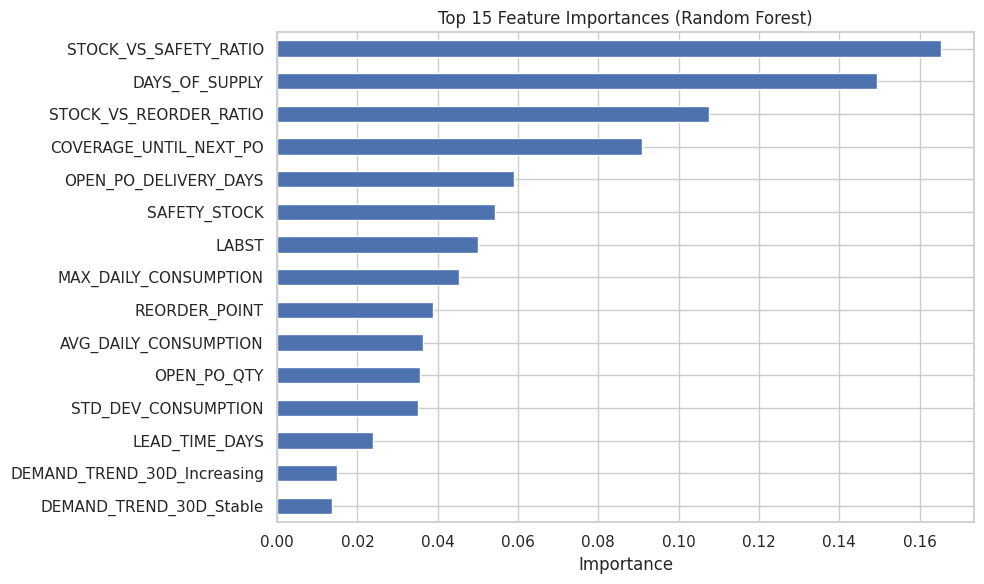

📥 Downloading top_features_importances PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# =====================================================
# FEATURE IMPORTANCE (Using RandomForest as explainer)
# =====================================================

# Feature importance (Random Forest) — robust version
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Use labeled subset
known_df = df[df['STOCKOUT_RISK_14D'].notna()].copy()
if len(known_df) < 10:
    print("Not enough labeled data for feature importance (need >= 10 labeled rows).")
else:
    # Clean up column names and select features
    feature_cols = [
        'LABST','SPEME','AVG_DAILY_CONSUMPTION','STD_DEV_CONSUMPTION','MAX_DAILY_CONSUMPTION',
        'DAYS_OF_SUPPLY','SAFETY_STOCK','REORDER_POINT','LEAD_TIME_DAYS',
        'STOCK_VS_REORDER_RATIO','STOCK_VS_SAFETY_RATIO','OPEN_PO_QTY','OPEN_PO_DELIVERY_DAYS','COVERAGE_UNTIL_NEXT_PO'
    ]
    # include categorical dummies
    cats = ['ABC_IND','SUPPLIER_RELIABILITY','DEMAND_TREND_30D','WERKS','MTART','MATKL','MRP_TYPE']
    enc_df = pd.get_dummies(known_df[feature_cols + cats], columns=cats, drop_first=True)

    # Target numeric mapping
    y = known_df['STOCKOUT_RISK_14D'].map({'HIGH':2,'MEDIUM':1,'LOW':0})
    # align shapes (in case)
    X = enc_df.reindex(index=y.index).fillna(0)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("Classification report (RF on labeled subset):")
    print(classification_report(y_test, preds, zero_division=0, target_names=['LOW','MEDIUM','HIGH']))

    importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_n = min(15, len(importances))

    plt.figure(figsize=(10,6))
    importances.head(top_n).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()

    # Save top features importance as PNG
    plt.savefig('top_features_importances.png', dpi=300, bbox_inches='tight') # Save first
    plt.show()

    # Download PNG file
    print("📥 Downloading top_features_importances PNG...")
    files.download('top_features_importances.png')


# Precision/Recall table for labeled predictions

* If you ran the RF block above you already printed classification report. If you want a concise table:

In [13]:
# Precision/Recall summary (use preds from RF block)
from sklearn.metrics import precision_recall_fscore_support

try:
    prf = precision_recall_fscore_support(y_test, preds, labels=[0,1,2], zero_division=0)
    summary = pd.DataFrame({
        'label':['LOW','MEDIUM','HIGH'],
        'precision':prf[0],
        'recall':prf[1],
        'f1':prf[2],
        'support':prf[3]
    })
    display(summary)
except NameError:
    print("Run the Feature Importance / RandomForest block first to compute predictions.")


,label,precision,recall,f1,support
0,LOW,0.500000,0.800000,0.615385,5
1,MEDIUM,0.666667,0.444444,0.533333,9
2,HIGH,0.833333,0.833333,0.833333,6


from matplotlib import pyplot as plt
summary['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='f1', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['precision']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['precision']
  ys = series['f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['precision']
  ys = series['support']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('support')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'precision'}, axis=1)
              .sort_values('precision', ascending=True))
  xs = counted['precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
summary['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='precision', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='recall', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='f1', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='support', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Scatterplot: Days of Supply vs Avg Consumption, colored by risk
* Uses labeled materials only (so color = risk).
* Uses a safe color mapping for HIGH/MEDIUM/LOW.

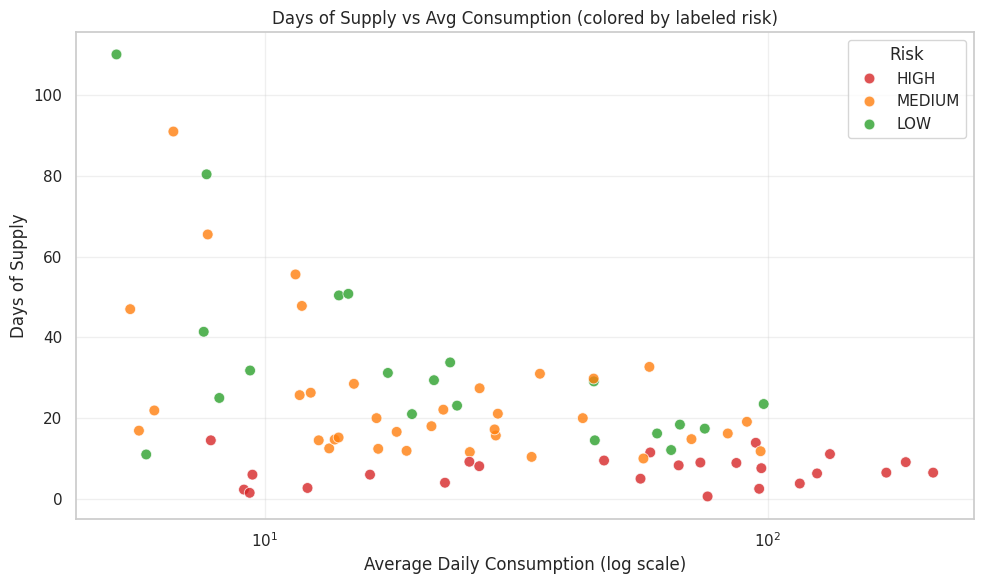

📥 Downloading days_sup_avg_consumtion PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# ==================================================================
# SCATTER: DAYS OF SUPPLY vs DAILY CONSUMPTION (Colored by Risk)
# ==================================================================

# Scatterplot: Days of Supply vs AVG_DAILY_CONSUMPTION, colored by STOCKOUT_RISK_14D
import seaborn as sns
import matplotlib.pyplot as plt

scatter_df = df[df['STOCKOUT_RISK_14D'].notna()].copy()
if scatter_df.empty:
    print("No labeled rows to plot scatter. Run the labeling/select-known-labels cell first.")
else:
    # Ensure categories are uppercase strings
    scatter_df['STOCKOUT_RISK_14D'] = scatter_df['STOCKOUT_RISK_14D'].astype(str).str.upper()
    # Safe palette mapping (covers HIGH/MEDIUM/LOW)
    palette = {'HIGH':'#d62728','MEDIUM':'#ff7f0e','LOW':'#2ca02c'}
    # If unexpected categories exist, build a fallback palette
    unique_cats = sorted(scatter_df['STOCKOUT_RISK_14D'].unique())
    missing = [c for c in unique_cats if c not in palette]
    if missing:
        # generate fallback colors
        uniq = unique_cats
        pal = sns.color_palette("tab10", len(uniq))
        palette = {c: pal[i] for i,c in enumerate(uniq)}

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=scatter_df,
        x='AVG_DAILY_CONSUMPTION',
        y='DAYS_OF_SUPPLY',
        hue='STOCKOUT_RISK_14D',
        palette=palette,
        alpha=0.8,
        s=60
    )
    plt.xscale('log')  # consumption can be skewed; log scale often helps interpretation
    plt.xlabel('Average Daily Consumption (log scale)')
    plt.ylabel('Days of Supply')
    plt.title('Days of Supply vs Avg Consumption (colored by labeled risk)')
    plt.legend(title='Risk')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save days_sup_avg_consumtion.png as PNG
    plt.savefig('days_sup_avg_consumtion.png', dpi=300, bbox_inches='tight') # Save first
    plt.show()

    # Download PNG file
    print("📥 Downloading days_sup_avg_consumtion PNG...")
    files.download('days_sup_avg_consumtion.png')


# Supplier risk bar: number of HIGH risk materials by supplier

* Shows which suppliers contribute most HIGH-risk materials.

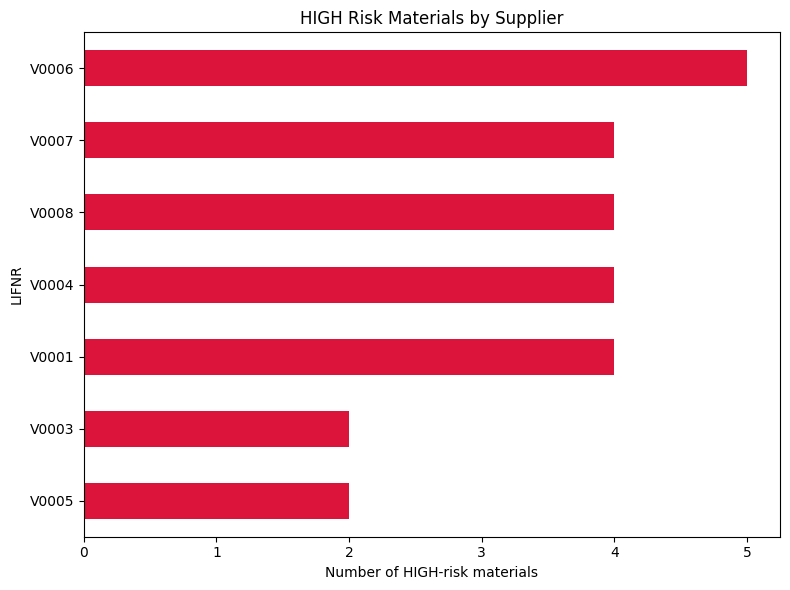

In [11]:
# Bar: HIGH risk counts by supplier (LIFNR)
high_df = df[df['STOCKOUT_RISK_14D'] == 'HIGH']
if high_df.empty:
    print("No HIGH labeled materials in the labeled subset.")
else:
    counts = high_df['LIFNR'].value_counts().sort_values(ascending=True)
    plt.figure(figsize=(8,6))
    counts.plot(kind='barh', color='crimson')
    plt.xlabel('Number of HIGH-risk materials')
    plt.title('HIGH Risk Materials by Supplier')
    plt.tight_layout()
    plt.show()


# Heatmap: Risk distribution by Plant (WERKS) and ABC class
* Cross-tab of counts (HIGH/MEDIUM/LOW) per Plant & ABC.

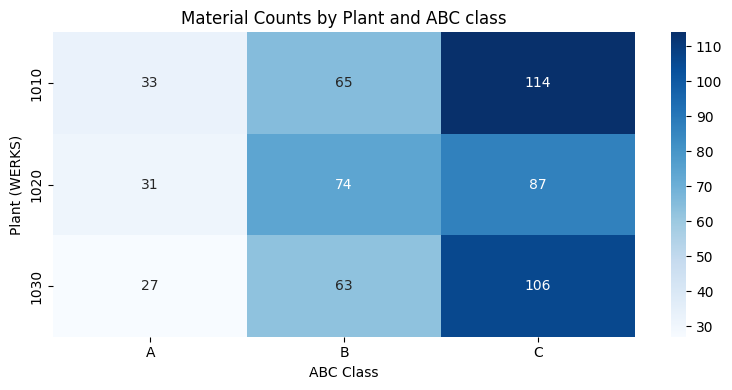

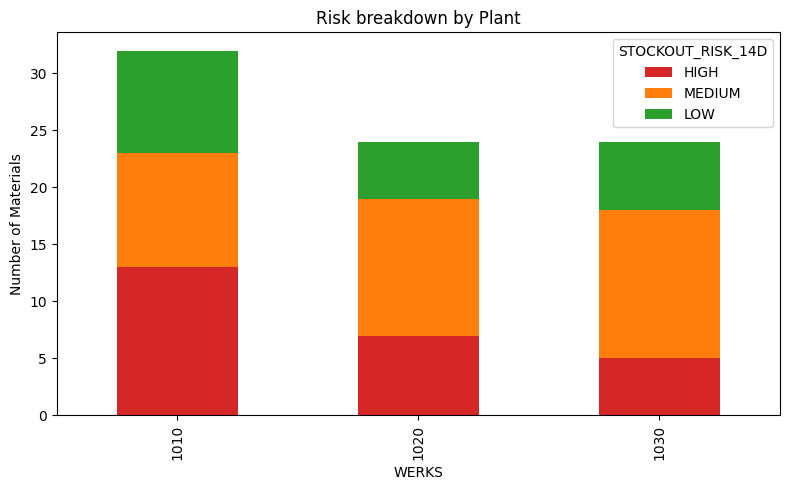

In [12]:
# Heatmap: risk distribution by plant and ABC class
pivot = pd.crosstab(df['WERKS'], df['ABC_IND'])
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Material Counts by Plant and ABC class')
plt.xlabel('ABC Class')
plt.ylabel('Plant (WERKS)')
plt.tight_layout()
plt.show()

# Also show risk breakdown (stacked bar)
risk_by_plant = pd.crosstab(df['WERKS'], df['STOCKOUT_RISK_14D']).fillna(0)
if risk_by_plant.sum().sum() == 0:
    print("No labeled risk counts to build risk-by-plant stacked bar.")
else:
    risk_by_plant[['HIGH','MEDIUM','LOW']].plot(kind='bar', stacked=True, figsize=(8,5), color=['#d62728','#ff7f0e','#2ca02c'])
    plt.title('Risk breakdown by Plant')
    plt.ylabel('Number of Materials')
    plt.tight_layout()
    plt.show()


## Ground Truth for validation - Calculation
Calculate the ground truth for all test materials.
We use the same risk function that generated the training labels.

In [5]:
# Calculate the ground truth for all test materials.
# We use the same risk function that generated the training labels.

def calculate_stockout_risk(row):
    """
    Calculate the risk of stockouts in the next 14 days
    Based on multiple factors, just like an expert planner would
    """
    risk_score = 0

    # Factor 1: Days of coverage
    if row['DAYS_OF_SUPPLY'] < 7:
        risk_score += 4
    elif row['DAYS_OF_SUPPLY'] < 14:
        risk_score += 3
    elif row['DAYS_OF_SUPPLY'] < 21:
        risk_score += 1

    # Factor 2: Stock vs safety stock
    if row['STOCK_VS_SAFETY_RATIO'] < 0.5:
        risk_score += 3
    elif row['STOCK_VS_SAFETY_RATIO'] < 1.0:
        risk_score += 2
    elif row['STOCK_VS_SAFETY_RATIO'] < 1.5:
        risk_score += 1

    # Factor 3: PO coverage
    if row['OPEN_PO_DELIVERY_DAYS'] == -999:  # No PO
        risk_score += 3
    elif row['OPEN_PO_DELIVERY_DAYS'] > row['DAYS_OF_SUPPLY']:
        risk_score += 2  # PO arrives after stockout
    elif row['OPEN_PO_DELIVERY_DAYS'] > 14:
        risk_score += 1  # distant PO

    # Factor 4: Supplier reliability
    if row['SUPPLIER_RELIABILITY'] == 'Low':
        risk_score += 2
    elif row['SUPPLIER_RELIABILITY'] == 'Medium':
        risk_score += 1

    # Factor 5: Demand trend
    if row['DEMAND_TREND_30D'] == 'Increasing':
        risk_score += 2
    elif row['DEMAND_TREND_30D'] == 'Decreasing':
        risk_score -= 1

    # Factor 6: Criticality (ABC)
    if row['ABC_IND'] == 'A':
        risk_score += 1  # More sensitive to stockouts

    # Factor 7: Demand volatility
    cv = row['STD_DEV_CONSUMPTION'] / row['AVG_DAILY_CONSUMPTION']  # Coefficient of variation
    if cv > 0.5:  # High volatility
        risk_score += 2
    elif cv > 0.3:
        risk_score += 1

    # Final standings
    if risk_score >= 8:
        return 'HIGH'
    elif risk_score >= 5:
        return 'MEDIUM'
    else:
        return 'LOW'

# Calculate ground truth para test set
print("Calculating ground truth for validation...")
test_df['TRUE_RISK'] = test_df.apply(calculate_stockout_risk, axis=1)

print("\n--- Ground Truth Distribution ---")
print(test_df['TRUE_RISK'].value_counts())

print("\n--- Predicted Distribution ---")
print(test_df['PREDICTED_RISK'].value_counts())

Calculating ground truth for validation...


NameError: name 'test_df' is not defined

# Complete ranking metrics

In [4]:
print("Recomputing TRUE_RISK to guarantee its presence...")

test_df = test_df.copy()   # avoid chained assignment issues

test_df['TRUE_RISK'] = test_df.apply(calculate_stockout_risk, axis=1)

print("OK. TRUE_RISK column created. Unique values:")
print(test_df['TRUE_RISK'].value_counts())


Recomputing TRUE_RISK to guarantee its presence...


NameError: name 'test_df' is not defined

CLASSIFICATION PERFORMANCE REPORT

Overall Accuracy: 75.58%

--- Classification Report ---
              precision    recall  f1-score   support

        HIGH      0.968     0.869     0.916       206
      MEDIUM      0.488     0.810     0.609       121
         LOW      0.866     0.601     0.709       193

    accuracy                          0.756       520
   macro avg      0.774     0.760     0.745       520
weighted avg      0.818     0.756     0.768       520


--- Confusion Matrix ---
             Pred HIGH  Pred MEDIUM  Pred LOW
True HIGH          179           26         1
True MEDIUM          6           98        17
True LOW             0           77       116

--- Key Metrics Interpretation ---
HIGH precision: 96.76% (when model says HIGH, how often is it right?)
HIGH recall: 86.89% (of all true HIGH risk, how many did we catch?)
HIGH → MEDIUM misclassification: 26 materials (acceptable)
HIGH → LOW misclassification: 1 materials (CRITICAL if >0!)

⚠️  WARNING: 1 critical 

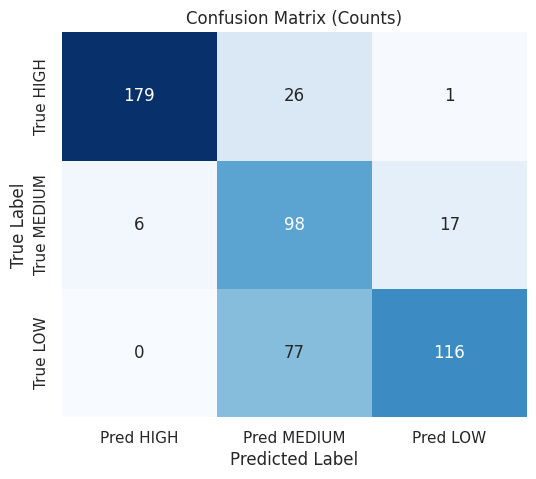

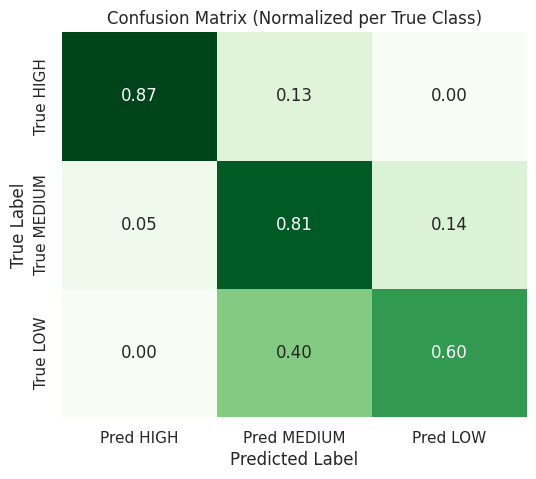

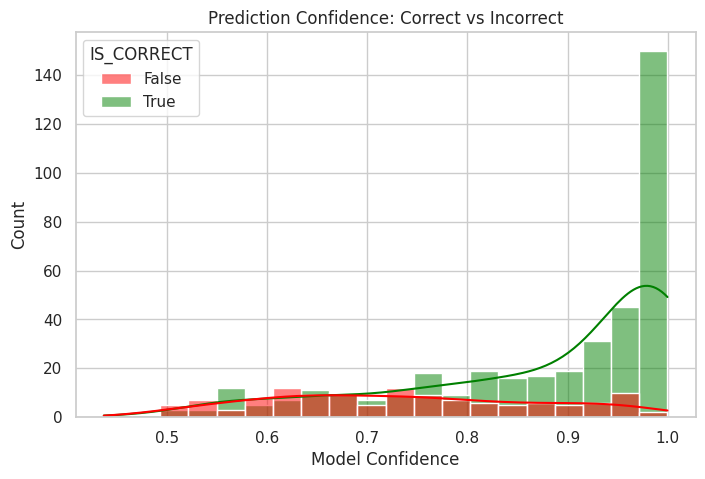

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

print("="*70)
print("CLASSIFICATION PERFORMANCE REPORT")
print("="*70)

# Overall accuracy
accuracy = accuracy_score(test_df['TRUE_RISK'], test_df['PREDICTED_RISK'])
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Classification report detallado
print("\n--- Classification Report ---")
report = classification_report(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW'],
    target_names=['HIGH', 'MEDIUM', 'LOW'],
    digits=3
)
print(report)

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW']
)

cm_df = pd.DataFrame(
    cm,
    index=['True HIGH', 'True MEDIUM', 'True LOW'],
    columns=['Pred HIGH', 'Pred MEDIUM', 'Pred LOW']
)

print(cm_df)

# Interpretation of the confusion matrix
print("\n--- Key Metrics Interpretation ---")
print(f"HIGH precision: {cm[0,0] / cm[:,0].sum():.2%} (when model says HIGH, how often is it right?)")
print(f"HIGH recall: {cm[0,0] / cm[0,:].sum():.2%} (of all true HIGH risk, how many did we catch?)")
print(f"HIGH → MEDIUM misclassification: {cm[0,1]} materials (acceptable)")
print(f"HIGH → LOW misclassification: {cm[0,2]} materials (CRITICAL if >0!)")

# Critical false negatives (predicted LOW but is HIGH)
false_negatives_critical = test_df[
    (test_df['TRUE_RISK'] == 'HIGH') &
    (test_df['PREDICTED_RISK'] == 'LOW')
]

if len(false_negatives_critical) > 0:
    print(f"\n⚠️  WARNING: {len(false_negatives_critical)} critical false negatives (missed HIGH risk)")
    print("These materials need manual review:")
    print(false_negatives_critical[['MATNR', 'WERKS', 'DAYS_OF_SUPPLY', 'PREDICTED_RISK', 'TRUE_RISK', 'CONFIDENCE']].head())
else:
    print("\n✅ No critical false negatives (no HIGH risk materials missed)")

# ============================================
# VISUAL EVALUATION PLOTS
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1) Confusion Matrix Heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.title("Confusion Matrix (Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- 2) Normalized Confusion Matrix ---
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_norm_df = pd.DataFrame(
    np.round(cm_normalized, 2),
    index=['True HIGH', 'True MEDIUM', 'True LOW'],
    columns=['Pred HIGH', 'Pred MEDIUM', 'Pred LOW']
)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm_df,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar=False
)
plt.title("Confusion Matrix (Normalized per True Class)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- 3) Confidence Distribution: Correct vs Incorrect predictions ---
test_df['IS_CORRECT'] = (test_df['TRUE_RISK'] == test_df['PREDICTED_RISK'])

plt.figure(figsize=(8,5))
sns.histplot(
    data=test_df,
    x='CONFIDENCE',
    hue='IS_CORRECT',
    bins=20,
    kde=True,
    palette={True: "green", False: "red"},
    alpha=0.5
)
plt.title("Prediction Confidence: Correct vs Incorrect")
plt.xlabel("Model Confidence")
plt.ylabel("Count")
plt.show()


In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("CLASSIFICATION PERFORMANCE REPORT")
print("="*70)

# ----------------------------------------------------------
# TEXTUAL METRICS
# ----------------------------------------------------------
accuracy = accuracy_score(test_df['TRUE_RISK'], test_df['PREDICTED_RISK'])
print(f"\nOverall Accuracy: {accuracy:.2%}")

report = classification_report(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW'],
    target_names=['HIGH', 'MEDIUM', 'LOW'],
    digits=3
)
print("\n--- Classification Report ---")
print(report)

cm = confusion_matrix(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW']
)

cm_df = pd.DataFrame(
    cm,
    index=['True HIGH', 'True MEDIUM', 'True LOW'],
    columns=['Pred HIGH', 'Pred MEDIUM', 'Pred LOW']
)

print("\n--- Confusion Matrix ---")
print(cm_df)

# Precision, recall, support per class
prec, rec, f1, support = precision_recall_fscore_support(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW']
)

# ----------------------------------------------------------
# INTERPRETATION
# ----------------------------------------------------------
print("\n--- Key Metrics Interpretation ---")
print(f"HIGH precision: {cm[0,0] / cm[:,0].sum():.2%}")
print(f"HIGH recall: {cm[0,0] / cm[0,:].sum():.2%}")
print(f"HIGH → MEDIUM misclassification: {cm[0,1]}")
print(f"HIGH → LOW misclassification: {cm[0,2]}")

false_negatives_critical = test_df[
    (test_df['TRUE_RISK'] == 'HIGH') &
    (test_df['PREDICTED_RISK'] == 'LOW')
]

if len(false_negatives_critical) > 0:
    print(f"\n⚠️  WARNING: {len(false_negatives_critical)} critical false negatives")
    print(false_negatives_critical[['MATNR','WERKS','DAYS_OF_SUPPLY','PREDICTED_RISK','TRUE_RISK','CONFIDENCE']].head())
else:
    print("\n✅ No critical false negatives")

# ----------------------------------------------------------
# 4-PLOT CLASSIFICATION DIAGNOSTICS (SUBPLOTS)
# ----------------------------------------------------------

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Classification Performance Visual Summary", fontsize=16)

# ---- 1. Confusion Matrix Heatmap ----
ax0 = ax[0, 0]
im = ax0.imshow(cm)
ax0.set_title("Confusion Matrix")
ax0.set_xticks(range(3))
ax0.set_xticklabels(['HIGH','MEDIUM','LOW'])
ax0.set_yticks(range(3))
ax0.set_yticklabels(['HIGH','MEDIUM','LOW'])
for i in range(3):
    for j in range(3):
        ax0.text(j, i, cm[i, j], ha='center', va='center')

# ---- 2. Normalized Confusion Matrix ----
ax1 = ax[0, 1]
cm_norm = cm / cm.sum(axis=1, keepdims=True)
im2 = ax1.imshow(cm_norm)
ax1.set_title("Normalized Confusion Matrix")
ax1.set_xticks(range(3))
ax1.set_xticklabels(['HIGH','MEDIUM','LOW'])
ax1.set_yticks(range(3))
ax1.set_yticklabels(['HIGH','MEDIUM','LOW'])
for i in range(3):
    for j in range(3):
        ax1.text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center')

# ---- 3. Precision & Recall Bars ----
ax2 = ax[1, 0]
x = np.arange(3)
ax2.bar(x - 0.15, prec, width=0.3, label="Precision")
ax2.bar(x + 0.15, rec, width=0.3, label="Recall")
ax2.set_xticks(x)
ax2.set_xticklabels(['HIGH','MEDIUM','LOW'])
ax2.set_title("Precision & Recall per Class")
ax2.legend()

# ---- 4. Support Counts ----
ax3 = ax[1, 1]
ax3.bar(['HIGH','MEDIUM','LOW'], support)
ax3.set_title("Support (Number of Samples per Class)")

plt.tight_layout()
plt.show()



# --- 3) Confidence Distribution: Correct vs Incorrect predictions ---
test_df['IS_CORRECT'] = (test_df['TRUE_RISK'] == test_df['PREDICTED_RISK'])

plt.figure(figsize=(8,5))
sns.histplot(
    data=test_df,
    x='CONFIDENCE',
    hue='IS_CORRECT',
    bins=20,
    kde=True,
    palette={True: "green", False: "red"},
    alpha=0.5
)
plt.title("Prediction Confidence: Correct vs Incorrect")
plt.xlabel("Model Confidence")
plt.ylabel("Count")
plt.show()


CLASSIFICATION PERFORMANCE REPORT


NameError: name 'test_df' is not defined

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*70)
print("CLASSIFICATION PERFORMANCE REPORT")
print("="*70)

# Overall accuracy
accuracy = accuracy_score(test_df['TRUE_RISK'], test_df['PREDICTED_RISK'])
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Classification report detallado
print("\n--- Classification Report ---")
report = classification_report(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW'],
    target_names=['HIGH', 'MEDIUM', 'LOW'],
    digits=3
)
print(report)

# Confusion Matrix (counts)
cm = confusion_matrix(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW']
)

cm_df = pd.DataFrame(
    cm,
    index=['True HIGH', 'True MEDIUM', 'True LOW'],
    columns=['Pred HIGH', 'Pred MEDIUM', 'Pred LOW']
)

print("\n--- Confusion Matrix (Counts) ---")
print(cm_df)

# Interpretation of the confusion matrix
print("\n--- Key Metrics Interpretation ---")
print(f"HIGH precision: {cm[0,0] / cm[:,0].sum():.2%} (when model says HIGH, how often is it right?)")
print(f"HIGH recall: {cm[0,0] / cm[0,:].sum():.2%} (of all true HIGH risk, how many did we catch?)")
print(f"HIGH → MEDIUM misclassification: {cm[0,1]} materials (acceptable)")
print(f"HIGH → LOW misclassification: {cm[0,2]} materials (CRITICAL if >0!)")

# Critical false negatives (predicted LOW but is HIGH)
false_negatives_critical = test_df[
    (test_df['TRUE_RISK'] == 'HIGH') &
    (test_df['PREDICTED_RISK'] == 'LOW')
]

if len(false_negatives_critical) > 0:
    print(f"\n⚠️  WARNING: {len(false_negatives_critical)} critical false negatives (missed HIGH risk)")
    print("These materials need manual review:")
    print(false_negatives_critical[['MATNR', 'WERKS', 'DAYS_OF_SUPPLY', 'PREDICTED_RISK', 'TRUE_RISK', 'CONFIDENCE']].head())
else:
    print("\n✅ No critical false negatives (no HIGH risk materials missed)")


# ============================================================
# 📊 ADDITIONAL VISUALIZATIONS: CONFUSION MATRIX SUBPLOTS
# ============================================================

# Normalized confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Raw counts (Blues) ---
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# --- Plot 2: Normalized (Greens) ---
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar=False,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

# ---- 3. Precision & Recall Bars ----
ax2 = ax[1, 0]
x = np.arange(3)
ax2.bar(x - 0.15, prec, width=0.3, label="Precision")
ax2.bar(x + 0.15, rec, width=0.3, label="Recall")
ax2.set_xticks(x)
ax2.set_xticklabels(['HIGH','MEDIUM','LOW'])
ax2.set_title("Precision & Recall per Class")
ax2.legend()

# ---- 4. Support Counts ----
ax3 = ax[1, 1]
ax3.bar(['HIGH','MEDIUM','LOW'], support)
ax3.set_title("Support (Number of Samples per Class)")

plt.tight_layout()
plt.show()



# --- 3) Confidence Distribution: Correct vs Incorrect predictions ---
test_df['IS_CORRECT'] = (test_df['TRUE_RISK'] == test_df['PREDICTED_RISK'])

plt.figure(figsize=(8,5))
sns.histplot(
    data=test_df,
    x='CONFIDENCE',
    hue='IS_CORRECT',
    bins=20,
    kde=True,
    palette={True: "green", False: "red"},
    alpha=0.5
)
plt.title("Prediction Confidence: Correct vs Incorrect")
plt.xlabel("Model Confidence")
plt.ylabel("Count")
plt.show()


CLASSIFICATION PERFORMANCE REPORT


NameError: name 'test_df' is not defined

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*70)
print("CLASSIFICATION PERFORMANCE REPORT")
print("="*70)

# Overall accuracy
accuracy = accuracy_score(test_df['TRUE_RISK'], test_df['PREDICTED_RISK'])
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Classification report detallado
print("\n--- Classification Report ---")
report = classification_report(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW'],
    target_names=['HIGH', 'MEDIUM', 'LOW'],
    digits=3,
    output_dict=True  # Para extraer métricas
)
print(classification_report(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW'],
    target_names=['HIGH', 'MEDIUM', 'LOW'],
    digits=3
))

# Extraer métricas para visualización
prec = [report['HIGH']['precision'], report['MEDIUM']['precision'], report['LOW']['precision']]
rec = [report['HIGH']['recall'], report['MEDIUM']['recall'], report['LOW']['recall']]
support = [report['HIGH']['support'], report['MEDIUM']['support'], report['LOW']['support']]

# Confusion Matrix (counts)
cm = confusion_matrix(
    test_df['TRUE_RISK'],
    test_df['PREDICTED_RISK'],
    labels=['HIGH', 'MEDIUM', 'LOW']
)

cm_df = pd.DataFrame(
    cm,
    index=['True HIGH', 'True MEDIUM', 'True LOW'],
    columns=['Pred HIGH', 'Pred MEDIUM', 'Pred LOW']
)

print("\n--- Confusion Matrix (Counts) ---")
print(cm_df)

# Interpretation of the confusion matrix
print("\n--- Key Metrics Interpretation ---")
print(f"HIGH precision: {cm[0,0] / cm[:,0].sum():.2%} (when model says HIGH, how often is it right?)")
print(f"HIGH recall: {cm[0,0] / cm[0,:].sum():.2%} (of all true HIGH risk, how many did we catch?)")
print(f"HIGH → MEDIUM misclassification: {cm[0,1]} materials (acceptable)")
print(f"HIGH → LOW misclassification: {cm[0,2]} materials (CRITICAL if >0!)")

# Critical false negatives (predicted LOW but is HIGH)
false_negatives_critical = test_df[
    (test_df['TRUE_RISK'] == 'HIGH') &
    (test_df['PREDICTED_RISK'] == 'LOW')
]

if len(false_negatives_critical) > 0:
    print(f"\n⚠️  WARNING: {len(false_negatives_critical)} critical false negatives (missed HIGH risk)")
    print("These materials need manual review:")
    print(false_negatives_critical[['MATNR', 'WERKS', 'DAYS_OF_SUPPLY', 'PREDICTED_RISK', 'TRUE_RISK', 'CONFIDENCE']].head())
else:
    print("\n✅ No critical false negatives (no HIGH risk materials missed)")


# ============================================================
# 📊 VISUALIZATIONS
# ============================================================

# --- Figure 1: Confusion Matrices ---
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Raw counts
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=axes1[0]
)
axes1[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')
axes1[0].set_ylabel("True Label")
axes1[0].set_xlabel("Predicted Label")

# Plot 2: Normalized
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2%",
    cmap="Greens",
    cbar=False,
    ax=axes1[1]
)
axes1[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')
axes1[1].set_ylabel("True Label")
axes1[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()


# --- Figure 2: Precision, Recall & Support ---
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision & Recall
x = np.arange(3)
width = 0.35
ax2[0].bar(x - width/2, prec, width, label="Precision", color='steelblue')
ax2[0].bar(x + width/2, rec, width, label="Recall", color='coral')
ax2[0].set_xticks(x)
ax2[0].set_xticklabels(['HIGH', 'MEDIUM', 'LOW'])
ax2[0].set_ylim([0, 1.1])
ax2[0].set_title("Precision & Recall per Class", fontsize=14, fontweight='bold')
ax2[0].set_ylabel("Score")
ax2[0].legend()
ax2[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (p, r) in enumerate(zip(prec, rec)):
    ax2[0].text(i - width/2, p + 0.02, f'{p:.2f}', ha='center', va='bottom', fontsize=9)
    ax2[0].text(i + width/2, r + 0.02, f'{r:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Support
ax2[1].bar(['HIGH', 'MEDIUM', 'LOW'], support, color=['#d62728', '#ff7f0e', '#2ca02c'])
ax2[1].set_title("Support (Samples per Class)", fontsize=14, fontweight='bold')
ax2[1].set_ylabel("Number of Samples")
ax2[1].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, s in enumerate(support):
    ax2[1].text(i, s + max(support)*0.02, f'{int(s)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


# --- Figure 3: Confidence Distribution ---
test_df['IS_CORRECT'] = (test_df['TRUE_RISK'] == test_df['PREDICTED_RISK'])

fig3, ax3 = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=test_df,
    x='CONFIDENCE',
    hue='IS_CORRECT',
    bins=20,
    kde=True,
    palette={True: "green", False: "red"},
    alpha=0.6,
    ax=ax3
)
ax3.set_title("Prediction Confidence: Correct vs Incorrect", fontsize=14, fontweight='bold')
ax3.set_xlabel("Model Confidence")
ax3.set_ylabel("Count")
ax3.legend(title='Prediction', labels=['Incorrect', 'Correct'])
plt.tight_layout()
plt.show()


# --- Figure 4: Error Analysis by Risk Level ---
fig4, ax4 = plt.subplots(figsize=(10, 6))

error_data = []
for true_label in ['HIGH', 'MEDIUM', 'LOW']:
    for pred_label in ['HIGH', 'MEDIUM', 'LOW']:
        count = len(test_df[(test_df['TRUE_RISK'] == true_label) &
                            (test_df['PREDICTED_RISK'] == pred_label)])
        error_data.append({
            'True': true_label,
            'Predicted': pred_label,
            'Count': count,
            'Error': true_label != pred_label
        })

error_df = pd.DataFrame(error_data)
error_df['Label'] = error_df['True'] + ' → ' + error_df['Predicted']
errors_only = error_df[error_df['Error'] == True].sort_values('Count', ascending=True)

if len(errors_only) > 0:
    ax4.barh(errors_only['Label'], errors_only['Count'], color='salmon')
    ax4.set_xlabel('Number of Misclassifications')
    ax4.set_title('Classification Errors Breakdown', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)

    # Añadir valores
    for i, (label, count) in enumerate(zip(errors_only['Label'], errors_only['Count'])):
        ax4.text(count + max(errors_only['Count'])*0.02, i, f'{int(count)}',
                va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("\n✅ Perfect classification - no errors to display!")

CLASSIFICATION PERFORMANCE REPORT


NameError: name 'test_df' is not defined

# Confidence analysis

In [32]:
print("="*70)
print("CONFIDENCE ANALYSIS")
print("="*70)

# Confidence stats por clase predicha
print("\n--- Confidence by Predicted Risk Level ---")
confidence_stats = test_df.groupby('PREDICTED_RISK')['CONFIDENCE'].describe()
print(confidence_stats)

# Simple visualisation (without matplotlib)
print("\n--- Confidence Distribution Summary ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        mean_conf = subset['CONFIDENCE'].mean()
        min_conf = subset['CONFIDENCE'].min()
        max_conf = subset['CONFIDENCE'].max()
        print(f"{risk_level:6s}: Mean={mean_conf:.3f}, Min={min_conf:.3f}, Max={max_conf:.3f}")

# HIGH risk materials with low confidence (review manually)
high_risk_low_conf = test_df[
    (test_df['PREDICTED_RISK'] == 'HIGH') &
    (test_df['CONFIDENCE'] < 0.6)
]

if len(high_risk_low_conf) > 0:
    print(f"\n⚠️  {len(high_risk_low_conf)} HIGH risk materials with LOW confidence (<0.6)")
    print("Recommend manual review for these:")
    print(high_risk_low_conf[['MATNR', 'WERKS', 'DAYS_OF_SUPPLY', 'CONFIDENCE', 'TRUE_RISK']].head(10))
else:
    print("\n✅ All HIGH risk predictions have confidence ≥0.6")

# Accuracy stratified by confidence
print("\n--- Accuracy by Confidence Threshold ---")
for threshold in [0.5, 0.6, 0.7, 0.8]:
    high_conf = test_df[test_df['CONFIDENCE'] >= threshold]
    if len(high_conf) > 0:
        acc = accuracy_score(high_conf['TRUE_RISK'], high_conf['PREDICTED_RISK'])
        print(f"Confidence ≥{threshold}: {len(high_conf):3d} materials ({len(high_conf)/len(test_df)*100:5.1f}%) → Accuracy: {acc:.2%}")

CONFIDENCE ANALYSIS

--- Confidence by Predicted Risk Level ---
                count      mean       std       min       25%       50%  \
PREDICTED_RISK                                                            
HIGH            185.0  0.935791  0.114156  0.502812  0.933392  0.993324   
LOW             134.0  0.837472  0.130620  0.522676  0.742959  0.868122   
MEDIUM          201.0  0.767054  0.146012  0.437098  0.639509  0.781191   

                     75%       max  
PREDICTED_RISK                      
HIGH            0.997769  0.999600  
LOW             0.957881  0.994657  
MEDIUM          0.906340  0.979577  

--- Confidence Distribution Summary ---
HIGH  : Mean=0.936, Min=0.503, Max=1.000
MEDIUM: Mean=0.767, Min=0.437, Max=0.980
LOW   : Mean=0.837, Min=0.523, Max=0.995

⚠️  5 HIGH risk materials with LOW confidence (<0.6)
Recommend manual review for these:
         MATNR  WERKS  DAYS_OF_SUPPLY  CONFIDENCE TRUE_RISK
236  MAT000237   1020             8.7    0.590561      HIGH
25

# Business Sanity Checks

In [ ]:
print("="*70)
print("BUSINESS VALIDATION - SANITY CHECKS")
print("="*70)

# Check 1: HIGH risk should have low coverage days
print("\n--- Check 1: Days of Supply by Risk Level ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        mean_dos = subset['DAYS_OF_SUPPLY'].mean()
        median_dos = subset['DAYS_OF_SUPPLY'].median()
        print(f"{risk_level:6s}: Mean={mean_dos:5.1f} days, Median={median_dos:5.1f} days")

# Check 2: HIGH risk should have more materials without PO
print("\n--- Check 2: Open PO Coverage by Risk Level ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        no_po_pct = (subset['OPEN_PO_QTY'] == 0).sum() / len(subset) * 100
        print(f"{risk_level:6s}: {no_po_pct:5.1f}% without open PO")

# Check 3: HIGH risk should have more Low reliability suppliers
print("\n--- Check 3: Supplier Reliability by Risk Level ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        low_reliability_pct = (subset['SUPPLIER_RELIABILITY'] == 'Low').sum() / len(subset) * 100
        print(f"{risk_level:6s}: {low_reliability_pct:5.1f}% with Low reliability suppliers")

# Check 4: HIGH risk should have low stock vs safety stock
print("\n--- Check 4: Stock vs Safety Stock Ratio by Risk Level ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        mean_ratio = subset['STOCK_VS_SAFETY_RATIO'].mean()
        below_safety = (subset['STOCK_VS_SAFETY_RATIO'] < 1.0).sum() / len(subset) * 100
        print(f"{risk_level:6s}: Mean ratio={mean_ratio:.2f}, {below_safety:5.1f}% below safety stock")

# Check 5: Class A materials should be more represented in HIGH risk.
print("\n--- Check 5: ABC Distribution by Risk Level ---")
for risk_level in ['HIGH', 'MEDIUM', 'LOW']:
    subset = test_df[test_df['PREDICTED_RISK'] == risk_level]
    if len(subset) > 0:
        abc_dist = subset['ABC_IND'].value_counts(normalize=True) * 100
        print(f"\n{risk_level}:")
        print(abc_dist.to_string())

print("\n" + "="*70)
print("✅ Business validation complete")
print("="*70)

BUSINESS VALIDATION - SANITY CHECKS

--- Check 1: Days of Supply by Risk Level ---
HIGH  : Mean=  5.9 days, Median=  5.9 days
MEDIUM: Mean= 25.5 days, Median= 21.9 days
LOW   : Mean= 36.9 days, Median= 28.9 days

--- Check 2: Open PO Coverage by Risk Level ---
HIGH  :  42.7% without open PO
MEDIUM:  45.3% without open PO
LOW   :  24.6% without open PO

--- Check 3: Supplier Reliability by Risk Level ---
HIGH  :  20.0% with Low reliability suppliers
MEDIUM:  23.9% with Low reliability suppliers
LOW   :  21.6% with Low reliability suppliers

--- Check 4: Stock vs Safety Stock Ratio by Risk Level ---
HIGH  : Mean ratio=0.57,  90.3% below safety stock
MEDIUM: Mean ratio=2.48,   8.5% below safety stock
LOW   : Mean ratio=3.80,   0.0% below safety stock

--- Check 5: ABC Distribution by Risk Level ---

HIGH:
ABC_IND
C    40.000000
B    36.216216
A    23.783784

MEDIUM:
ABC_IND
C    52.238806
B    33.333333
A    14.427861

LOW:
ABC_IND
C    60.447761
B    33.582090
A     5.970149

✅ Business 

# Train vs Test Comparison (Distribution Shift)

In [ ]:
print("="*70)
print("TRAIN vs TEST DISTRIBUTION CHECK")
print("="*70)

# Compare distributions of key features
key_features = ['DAYS_OF_SUPPLY', 'STOCK_VS_SAFETY_RATIO', 'LEAD_TIME_DAYS']

print("\n--- Feature Distribution Comparison ---")
for feature in key_features:
    print(f"\n{feature}:")
    print(f"  Train: Mean={train_df[feature].mean():6.2f}, Std={train_df[feature].std():6.2f}")
    print(f"  Test:  Mean={test_df[feature].mean():6.2f}, Std={test_df[feature].std():6.2f}")

# Compare target distribution
print("\n--- Risk Distribution Comparison ---")
print("\nTraining set:")
print(train_df['STOCKOUT_RISK_14D'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

print("\nTest set (Ground Truth):")
print(test_df['TRUE_RISK'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

print("\nTest set (Predictions):")
print(test_df['PREDICTED_RISK'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Check: ¿Las distribuciones son similares?
train_high_pct = (train_df['STOCKOUT_RISK_14D'] == 'HIGH').sum() / len(train_df)
test_high_pct = (test_df['TRUE_RISK'] == 'HIGH').sum() / len(test_df)
pred_high_pct = (test_df['PREDICTED_RISK'] == 'HIGH').sum() / len(test_df)

print(f"\nHIGH risk percentage:")
print(f"  Training:   {train_high_pct:.1%}")
print(f"  Test (true): {test_high_pct:.1%}")
print(f"  Test (pred): {pred_high_pct:.1%}")

if abs(train_high_pct - test_high_pct) < 0.05:
    print("\n✅ Train and test distributions are similar (good)")
else:
    print("\n⚠️  Distribution shift detected between train and test")

TRAIN vs TEST DISTRIBUTION CHECK

--- Feature Distribution Comparison ---

DAYS_OF_SUPPLY:
  Train: Mean= 21.47, Std= 19.65
  Test:  Mean= 21.48, Std= 19.11

STOCK_VS_SAFETY_RATIO:
  Train: Mean=  2.01, Std=  1.72
  Test:  Mean=  2.14, Std=  2.01

LEAD_TIME_DAYS:
  Train: Mean= 21.76, Std= 13.48
  Test:  Mean= 22.88, Std= 13.77

--- Risk Distribution Comparison ---

Training set:
STOCKOUT_RISK_14D
MEDIUM    43.8%
HIGH      31.2%
LOW       25.0%
Name: proportion, dtype: object

Test set (Ground Truth):
TRUE_RISK
HIGH      39.6%
LOW       37.1%
MEDIUM    23.3%
Name: proportion, dtype: object

Test set (Predictions):
PREDICTED_RISK
MEDIUM    38.7%
HIGH      35.6%
LOW       25.8%
Name: proportion, dtype: object

HIGH risk percentage:
  Training:   31.2%
  Test (true): 39.6%
  Test (pred): 35.6%

⚠️  Distribution shift detected between train and test


# Complete export of results

In [ ]:
print("="*70)
print("EXPORTING RESULTS")
print("="*70)

# 1. Export HIGH risk with all columns + prediction
high_risk_full = test_df[test_df['PREDICTED_RISK'] == 'HIGH'].copy()
high_risk_full = high_risk_full.sort_values('CONFIDENCE', ascending=False)
high_risk_full.to_csv('HIGH_RISK_materials_full_analysis.csv', index=False)
print(f"\n✅ Exported {len(high_risk_full)} HIGH risk materials")
print("   File: HIGH_RISK_materials_full_analysis.csv")

# 2. Export validation report (predicción vs ground truth)
validation_df = test_df[['MATNR', 'WERKS', 'ABC_IND', 'DAYS_OF_SUPPLY',
                          'OPEN_PO_DELIVERY_DAYS', 'SUPPLIER_RELIABILITY',
                          'TRUE_RISK', 'PREDICTED_RISK', 'CONFIDENCE']].copy()
validation_df['MATCH'] = validation_df['TRUE_RISK'] == validation_df['PREDICTED_RISK']
validation_df.to_csv('validation_results.csv', index=False)
print(f"\n✅ Exported validation results for all {len(validation_df)} test materials")
print("   File: validation_results.csv")

# 3. Export summary statistics
summary_stats = {
    'Total Materials': len(test_df),
    'Accuracy': accuracy_score(test_df['TRUE_RISK'], test_df['PREDICTED_RISK']),
    'HIGH Precision': cm[0,0] / cm[:,0].sum() if cm[:,0].sum() > 0 else 0,
    'HIGH Recall': cm[0,0] / cm[0,:].sum() if cm[0,:].sum() > 0 else 0,
    'HIGH Predicted': (test_df['PREDICTED_RISK'] == 'HIGH').sum(),
    'HIGH True': (test_df['TRUE_RISK'] == 'HIGH').sum(),
    'Avg Confidence HIGH': test_df[test_df['PREDICTED_RISK'] == 'HIGH']['CONFIDENCE'].mean(),
    'Prediction Time (sec)': prediction_time,
    'Throughput (materials/sec)': len(test_df) / prediction_time
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('model_performance_summary.csv', index=False)
print(f"\n✅ Exported performance summary")
print("   File: model_performance_summary.csv")

print("\n" + "="*70)
print("ALL EXPORTS COMPLETE")
print("="*70)

# Display summary
print("\n--- Final Summary ---")
for key, value in summary_stats.items():
    if 'Time' in key or 'Throughput' in key:
        print(f"{key:30s}: {value:.3f}")
    elif 'Precision' in key or 'Recall' in key or 'Accuracy' in key or 'Confidence' in key:
        print(f"{key:30s}: {value:.2%}")
    else:
        print(f"{key:30s}: {value}")

EXPORTING RESULTS

✅ Exported 185 HIGH risk materials
   File: HIGH_RISK_materials_full_analysis.csv

✅ Exported validation results for all 520 test materials
   File: validation_results.csv

✅ Exported performance summary
   File: model_performance_summary.csv

ALL EXPORTS COMPLETE

--- Final Summary ---
Total Materials               : 520
Accuracy                      : 75.58%
HIGH Precision                : 96.76%
HIGH Recall                   : 86.89%
HIGH Predicted                : 185
HIGH True                     : 206
Avg Confidence HIGH           : 93.58%
Prediction Time (sec)         : 0.967
Throughput (materials/sec)    : 537.598


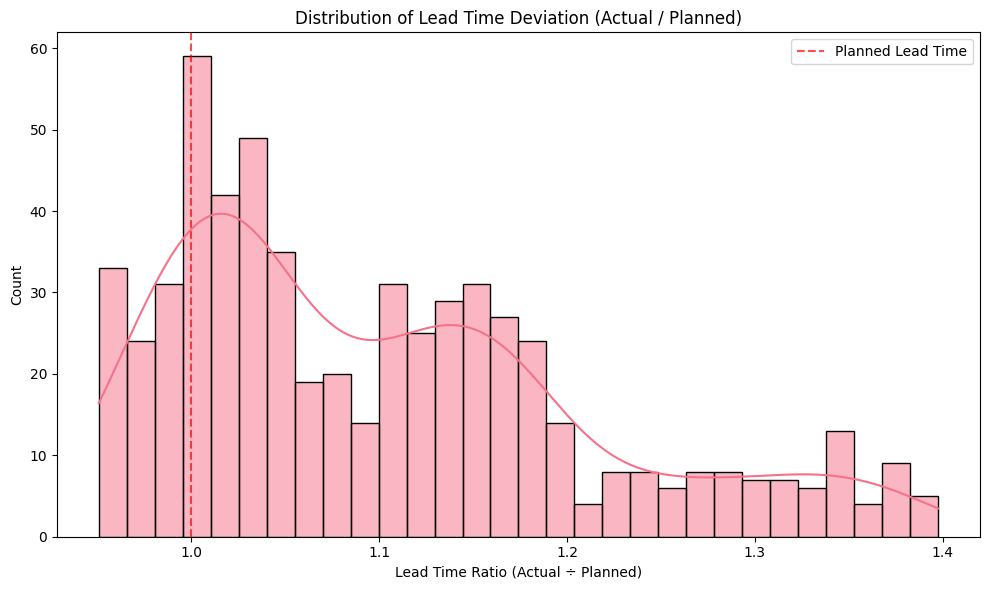

In [ ]:
# ===========================================================
# LEAD TIME DEVIATION DISTRIBUTION
# ===========================================================

plt.figure(figsize=(10, 6))
sns.histplot(df['ACTUAL_VS_PLANNED_LT'], kde=True, bins=30)
plt.axvline(1.0, color='red', linestyle='--', alpha=0.7, label='Planned Lead Time')
plt.title("Distribution of Lead Time Deviation (Actual / Planned)")
plt.xlabel("Lead Time Ratio (Actual ÷ Planned)")
plt.legend()
plt.tight_layout()
plt.show()


combined

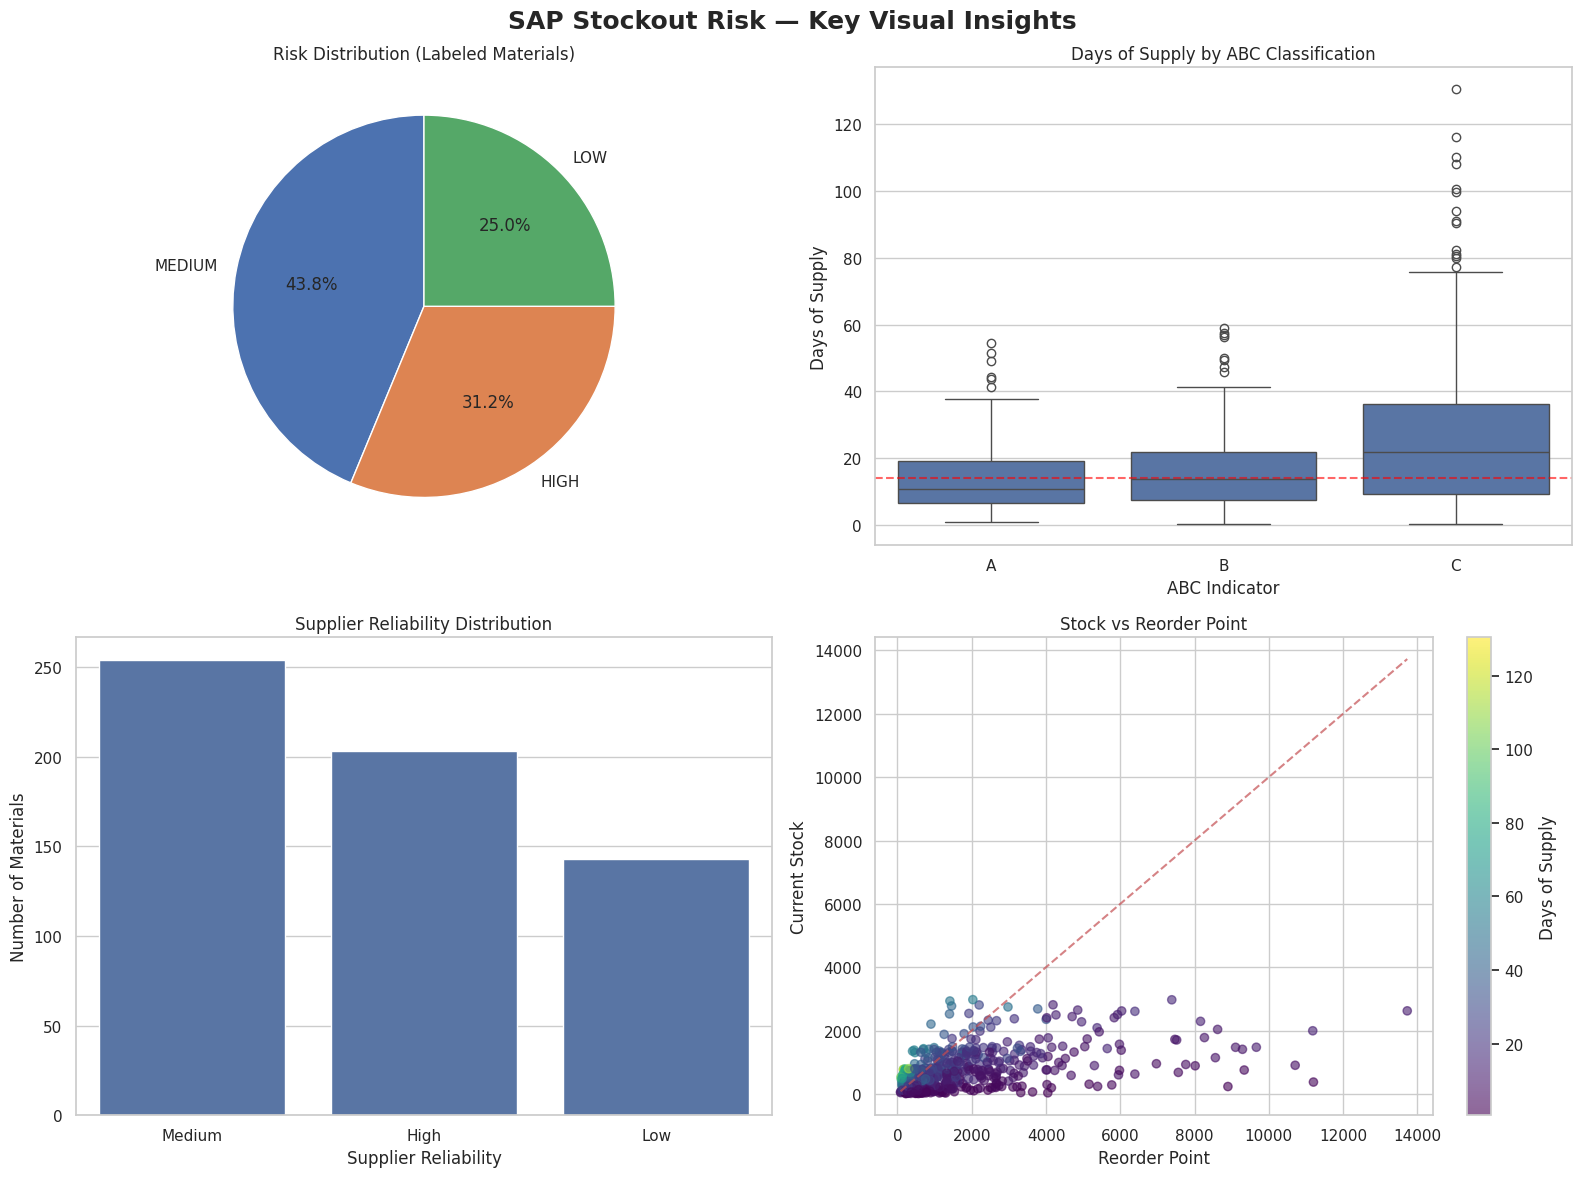

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure figure styling is clean
sns.set(style="whitegrid")

# Prepare known-risk subset for plots that need labels
known_df = df[df['STOCKOUT_RISK_14D'].notna()].copy()

# Start figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("SAP Stockout Risk — Key Visual Insights", fontsize=18, fontweight="bold")

# ============================================================
# 1️⃣ Risk Distribution (only where risk labels exist)
# ============================================================
ax = axes[0, 0]

if not known_df.empty:
    risk_counts = known_df['STOCKOUT_RISK_14D'].value_counts()
    ax.pie(
        risk_counts.values,
        labels=risk_counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    ax.set_title("Risk Distribution (Labeled Materials)")
else:
    ax.text(0.5, 0.5, "No labeled risk data available", ha="center", va="center")
    ax.set_title("Risk Distribution")

# ============================================================
# 2️⃣ Days of Supply by ABC Class
# ============================================================
ax = axes[0, 1]
sns.boxplot(data=df, x='ABC_IND', y='DAYS_OF_SUPPLY', ax=ax)
ax.axhline(y=14, color='red', linestyle='--', alpha=0.6)
ax.set_title("Days of Supply by ABC Classification")
ax.set_xlabel("ABC Indicator")
ax.set_ylabel("Days of Supply")

# ============================================================
# 3️⃣ Supplier Reliability Distribution
# ============================================================
ax = axes[1, 0]
supplier_counts = df['SUPPLIER_RELIABILITY'].value_counts()
sns.barplot(x=supplier_counts.index, y=supplier_counts.values, ax=ax)
ax.set_title("Supplier Reliability Distribution")
ax.set_ylabel("Number of Materials")
ax.set_xlabel("Supplier Reliability")

# ============================================================
# 4️⃣ Stock vs Reorder Point (colored by Days of Supply)
# ============================================================
ax = axes[1, 1]
scatter = ax.scatter(
    df['REORDER_POINT'],
    df['LABST'],
    c=df['DAYS_OF_SUPPLY'],
    cmap='viridis',
    alpha=0.6
)
ax.plot(
    [df['REORDER_POINT'].min(), df['REORDER_POINT'].max()],
    [df['REORDER_POINT'].min(), df['REORDER_POINT'].max()],
    'r--',
    alpha=0.7
)
ax.set_title("Stock vs Reorder Point")
ax.set_xlabel("Reorder Point")
ax.set_ylabel("Current Stock")

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Days of Supply")

# ============================================================

plt.tight_layout()
plt.show()
